# Quantum annealing time evolution
## Albert Molina

Here I will be coding my Hamiltonians and time evolution for the p-shell nuclei studied in the paper ($^{8}Be, ^{10}Be, ^{12}Be$)

In [1]:
import scipy as sp
import numpy as np
from scipy.sparse.linalg import eigsh, expm_multiply
from scipy.linalg import eigvalsh 
import matplotlib.pyplot as plt
from src.hamiltonian_utils import FermiHubbardHamiltonian # the many-body Hamiltonian class
from src.nuclear_physics_utils import SingleParticleState,J2operator,get_twobody_nuclearshell_model # routines and class useful for the nuclear part

In [2]:
p_shell = 'data/cki'

SPS = SingleParticleState(file_name = p_shell)

# Let's print the single particle energies
print('single particle energies =', SPS.energies)
print('mapping between nucleon modes a and quantum numbers:', SPS.state_encoding)

nuc_modes_per_i = SPS.energies.shape[0] // 2   # counting per species!!

single particle energies = [1.63 1.63 1.63 1.63 2.27 2.27 1.63 1.63 1.63 1.63 2.27 2.27]
mapping between nucleon modes a and quantum numbers: [(0, 1, 1.5, -1.5, 0.5, 0.5), (0, 1, 1.5, -0.5, 0.5, 0.5), (0, 1, 1.5, 0.5, 0.5, 0.5), (0, 1, 1.5, 1.5, 0.5, 0.5), (0, 1, 0.5, -0.5, 0.5, 0.5), (0, 1, 0.5, 0.5, 0.5, 0.5), (0, 1, 1.5, -1.5, 0.5, -0.5), (0, 1, 1.5, -0.5, 0.5, -0.5), (0, 1, 1.5, 0.5, 0.5, -0.5), (0, 1, 1.5, 1.5, 0.5, -0.5), (0, 1, 0.5, -0.5, 0.5, -0.5), (0, 1, 0.5, 0.5, 0.5, -0.5)]


## $^{8}Be$

Now, let us initialize our Target Hamiltonian $\rightarrow$ NSM Hamiltonian for $^{8}Be$

In [3]:
# Let's start with 8-Be (2 protons and 2 neutrons in p-shell):
p = 2
n_eight = 2

NSM_H_eight = FermiHubbardHamiltonian(size_a=nuc_modes_per_i, size_b=nuc_modes_per_i, nparticles_a=p, nparticles_b=n_eight, 
                                symmetries=[SPS.total_M_zero]) # we force M=0 so we don't get the full manybody basis
# Also, I changed Ema's code where a was neutrons and b protons, since they're just numbers (and the same in this case)

NSM_H_eight.get_external_potential(external_potential=SPS.energies)
twobody_dict_eight, _ = get_twobody_nuclearshell_model(file_name=p_shell)

NSM_H_eight.get_twobody_interaction(twobody_dict_eight)
NSM_H_eight.get_hamiltonian() # Now we have the Target Hamiltonian ready

egs_eight, psigs_eight = NSM_H_eight.get_spectrum(n_states=1) # just the ground state (energy in MeV's)
print(f'GS energy = {egs_eight[0]:.5} MeV')
print(NSM_H_eight.hamiltonian)


Computing the matrix, pls wait... (u_u) 



100%|██████████| 12/12 [00:01<00:00,  8.02it/s]
1424it [00:02, 538.17it/s]


GS energy = -30.295 MeV
  (0, 0)	-6.582989999999999
  (0, 1)	2.002499032786363
  (0, 2)	-2.315995000000001
  (0, 3)	0.17580399459981977
  (0, 4)	-0.10150048360681718
  (0, 5)	-1.052265
  (0, 6)	1.9530200000000002
  (0, 8)	1.9009985491795476
  (0, 10)	2.002499032786366
  (0, 11)	-1.7096958900278656
  (0, 12)	-0.10150048360681718
  (0, 13)	0.5966341818903774
  (0, 14)	2.054162795550007
  (0, 15)	1.9530199999999995
  (0, 16)	-1.0522650000000002
  (0, 18)	-1.9009985491795478
  (0, 20)	-0.9007550000000002
  (0, 23)	0.17580399459982032
  (0, 24)	1.3652289845057242
  (0, 25)	0.5966341818903769
  (0, 26)	1.9009985491795474
  (0, 27)	-1.9009985491795478
  (0, 29)	-2.3986297010721485
  (1, 0)	2.002499032786363
  (1, 1)	-5.3826374999999995
  :	:
  (49, 49)	-3.0554875000000017
  (49, 50)	1.1102230246251565e-16
  (50, 9)	-3.763858685577873
  (50, 11)	-2.3986297010721485
  (50, 13)	0.5966341818903769
  (50, 14)	1.3652289845057242
  (50, 19)	3.763858685577873
  (50, 24)	2.054162795550007
  (50, 25)	0

Now, let's get our Driver Hamiltonian.

We have to consider the initial state, which in this case is the minimum energy Slater determinant.

In [4]:
# # We select the product state of the basis that minimizes the Hamiltonian
# min = 10000
# min_b_eight = 0.

# for i, b in enumerate(NSM_H_eight.basis):
#     psi = np.zeros(NSM_H_eight.basis.shape[0]) # we initialize the state
#     psi[i] = 1.0
#     val = np.conj(psi) @ NSM_H_eight.hamiltonian @ psi
#     if val < min:
#         min = val # Minimum energy!
#         psi_base = psi 
#         min_b_eight = b
# print('MINIMUM BASIS:',min_b_eight) # THIS is the minimum energy Slater determinant
# psi_ini_eight = psi_base.copy()

ini_base_el_eight = np.array([1.,0.,0.,1.,0.,0.,1.,0.,0.,1.,0.,0.])
ini_idx = NSM_H_eight._get_index(ini_base_el_eight)
psi_ini_eight = np.zeros(NSM_H_eight.hamiltonian.shape[0])
psi_ini_eight[ini_idx] = 1
print(psi_ini_eight)

[0. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0.]


Then we define our external potential, following the description from the paper

In [5]:
# ext_pot_eight = np.zeros(2 * nuc_modes_per_i)
# print(ext_pot_eight.shape)
# ext_pot_eight = (min / (p + n_eight)) * min_b_eight
# extpot = (-1)*psi_ini.conjugate()*...
ext_pot_eight = (NSM_H_eight.hamiltonian[ini_idx,ini_idx] / (p+ n_eight)) * ini_base_el_eight

We can initialize our Driver Hamiltonian

In [6]:
Driver_H_eight = FermiHubbardHamiltonian(size_a=nuc_modes_per_i, size_b=nuc_modes_per_i, nparticles_a=p, nparticles_b=n_eight, 
                                        symmetries=[SPS.total_M_zero])
Driver_H_eight.get_external_potential(ext_pot_eight)
Driver_H_eight.get_hamiltonian()
print(Driver_H_eight.hamiltonian)

  (0, 0)	-7.702854999999998
  (1, 1)	-7.702854999999998
  (2, 2)	-7.702854999999998
  (3, 3)	-3.851427499999999
  (4, 4)	-7.702854999999998
  (5, 5)	-15.405709999999996
  (6, 6)	-7.702854999999998
  (7, 7)	-7.702854999999998
  (8, 8)	-7.702854999999998
  (9, 9)	-7.702854999999998
  (10, 10)	-7.702854999999998
  (11, 11)	-7.702854999999998
  (12, 12)	-7.702854999999998
  (13, 13)	-3.851427499999999
  (14, 14)	-7.702854999999998
  (15, 15)	-7.702854999999998
  (20, 20)	-7.702854999999998
  (21, 21)	-7.702854999999998
  (22, 22)	-3.851427499999999
  (23, 23)	-3.851427499999999
  (25, 25)	-3.851427499999999
  (26, 26)	-7.702854999999998
  (31, 31)	-7.702854999999998
  (32, 32)	-7.702854999999998
  (33, 33)	-7.702854999999998
  (38, 38)	-3.851427499999999
  (39, 39)	-3.851427499999999
  (41, 41)	-7.702854999999998
  (42, 42)	-7.702854999999998
  (43, 43)	-3.851427499999999
  (44, 44)	-7.702854999999998
  (45, 45)	-7.702854999999998
  (46, 46)	-7.702854999999998


Now, let's perform the adiabatic evolution

c:\Users\alber\anaconda3\Lib\site-packages\matplotlib\cbook\__init__.py:1340: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


FINAL ENERGIES (in MeV)
tf=10 -> -30.291376100358363
tf=8 -> -30.285652803733825
tf=5 -> -30.261374722708318
tf=2 -> -29.987295423677516
GS energy = -30.295 MeV


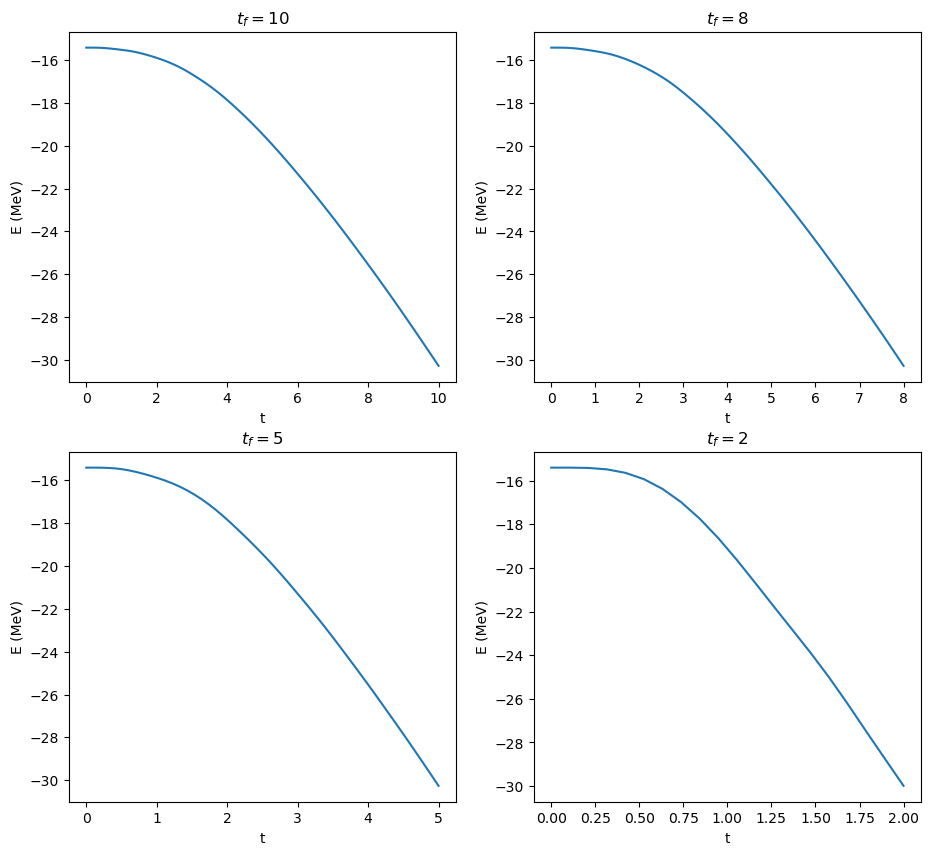

In [7]:
tf = 10
tsteps = 100
dt = tf / tsteps
time10 = np.linspace(0, tf, tsteps)

psi_eight = psi_ini_eight.copy()
energy_eight = []
spectrum_t_eight = []
prob_eightarr = []

for i, t in enumerate(time10):
    prob_eight = []
    H_t_eight = (1 - t/tf) * Driver_H_eight.hamiltonian + (t/tf) * NSM_H_eight.hamiltonian
    energy_eight.append(psi_eight.conjugate().transpose().dot(H_t_eight.dot(psi_eight))) # we append <psi(t)|H(t)|psi(t)>
    eigval_eight, eigvec_eight = eigsh(H_t_eight, k=5, which='SA')
    spectrum_t_eight.append(eigval_eight)
    psi_eight = expm_multiply(-1j * dt * H_t_eight,psi_eight)
    for k in range(1,5):
        prob_eight.append(np.linalg.norm(psi_eight.conjugate().dot(eigvec_eight[:,k]))**2.0)
    prob_eightarr.append(prob_eight)
prob_eightarr10 = np.asarray(prob_eightarr)
spectrum_arr10 = np.asarray(spectrum_t_eight)
energy_eight10 = energy_eight
# We plot the energy along time
plt.figure('exp. value of E',figsize=(11, 10))
plt.subplot(221)
plt.title('$t_f = 10$')
plt.plot(time10, energy_eight10)
plt.xlabel('t')
plt.ylabel('E (MeV)')


# Now let's perform the annealing for shorter times, also a dt=0.1
# FINAL TIME -> 8
tsteps8 = 80
dt = 8 / tsteps8
time8 = np.linspace(0, 8, tsteps8)

psi_eight = psi_ini_eight.copy()
energy_eight = []
spectrum_t_eight = []
prob_eightarr = []

for i, t in enumerate(time8):
    prob_eight = []
    H_t_eight = (1 - t/8) * Driver_H_eight.hamiltonian + (t/8) * NSM_H_eight.hamiltonian
    energy_eight.append(psi_eight.conjugate().transpose().dot(H_t_eight.dot(psi_eight))) # we append <psi(t)|H(t)|psi(t)>
    eigval_eight, eigvec_eight = eigsh(H_t_eight, k=5, which='SA')
    spectrum_t_eight.append(eigval_eight)
    psi_eight = expm_multiply(-1j * dt * H_t_eight,psi_eight)
    for k in range(1,5):
        prob_eight.append(np.linalg.norm(psi_eight.conjugate().dot(eigvec_eight[:,k]))**2.0)
    prob_eightarr.append(prob_eight)
prob_eightarr8 = np.asarray(prob_eightarr)
spectrum_arr8 = np.asarray(spectrum_t_eight)
energy_eight8 = energy_eight
# We plot the energy along time
plt.subplot(222)
plt.title('$t_f = 8$')
plt.plot(time8, energy_eight8)
plt.xlabel('t')
plt.ylabel('E (MeV)')

# FINAL TIME -> 5
tsteps5 = 50
dt = 5 / tsteps5
time5 = np.linspace(0, 5, tsteps5)

psi_eight = psi_ini_eight.copy()
energy_eight = []
spectrum_t_eight = []
prob_eightarr = []

for i, t in enumerate(time5):
    prob_eight = []
    H_t_eight = (1 - t/5) * Driver_H_eight.hamiltonian + (t/5) * NSM_H_eight.hamiltonian
    energy_eight.append(psi_eight.conjugate().transpose().dot(H_t_eight.dot(psi_eight))) # we append <psi(t)|H(t)|psi(t)>
    eigval_eight, eigvec_eight = eigsh(H_t_eight, k=5, which='SA')
    spectrum_t_eight.append(eigval_eight)
    psi_eight = expm_multiply(-1j * dt * H_t_eight,psi_eight)
    for k in range(1,5):
        prob_eight.append(np.linalg.norm(psi_eight.conjugate().dot(eigvec_eight[:,k]))**2.0)
    prob_eightarr.append(prob_eight)
prob_eightarr5 = np.asarray(prob_eightarr)
spectrum_arr5 = np.asarray(spectrum_t_eight)
energy_eight5 = energy_eight
# We plot the energy along time
plt.subplot(223)
plt.title('$t_f = 5$')
plt.plot(time5, energy_eight5)
plt.xlabel('t')
plt.ylabel('E (MeV)')

# FINAL TIME -> 2
tsteps2 = 20
dt = 2 / tsteps2
time2 = np.linspace(0, 2, tsteps2)

psi_eight = psi_ini_eight.copy()
energy_eight = []
spectrum_t_eight = []
prob_eightarr = []

for i, t in enumerate(time2):
    prob_eight = []
    H_t_eight = (1 - t/2) * Driver_H_eight.hamiltonian + (t/2) * NSM_H_eight.hamiltonian
    energy_eight.append(psi_eight.conjugate().transpose().dot(H_t_eight.dot(psi_eight))) # we append <psi(t)|H(t)|psi(t)>
    eigval_eight, eigvec_eight = eigsh(H_t_eight, k=5, which='SA')
    spectrum_t_eight.append(eigval_eight)
    psi_eight = expm_multiply(-1j * dt * H_t_eight,psi_eight)
    for k in range(1,5):
        prob_eight.append(np.linalg.norm(psi_eight.conjugate().dot(eigvec_eight[:,k]))**2.0)
    prob_eightarr.append(prob_eight)
prob_eightarr2 = np.asarray(prob_eightarr)
spectrum_arr2 = np.asarray(spectrum_t_eight)
energy_eight2 = energy_eight
# We plot the energy along time
plt.subplot(224)
plt.title('$t_f = 2$')
plt.plot(time2, energy_eight2)
plt.xlabel('t')
plt.ylabel('E (MeV)')

# Let's print the final energies, compared to the GS
print('FINAL ENERGIES (in MeV)')
print('tf=10 ->', np.real(energy_eight10[tsteps-1]))
print('tf=8 ->', np.real(energy_eight8[tsteps8-1]))
print('tf=5 ->', np.real(energy_eight5[tsteps5-1]))
print('tf=2 ->', np.real(energy_eight2[tsteps2-1]))
print(f'GS energy = {egs_eight[0]:.5} MeV')

We see that the energy at the end of the process is the same as the GS energy of the NSM $\rightarrow$ well executed!

Finally, let's compare the plot above with part of the spectrum of $H(t)$

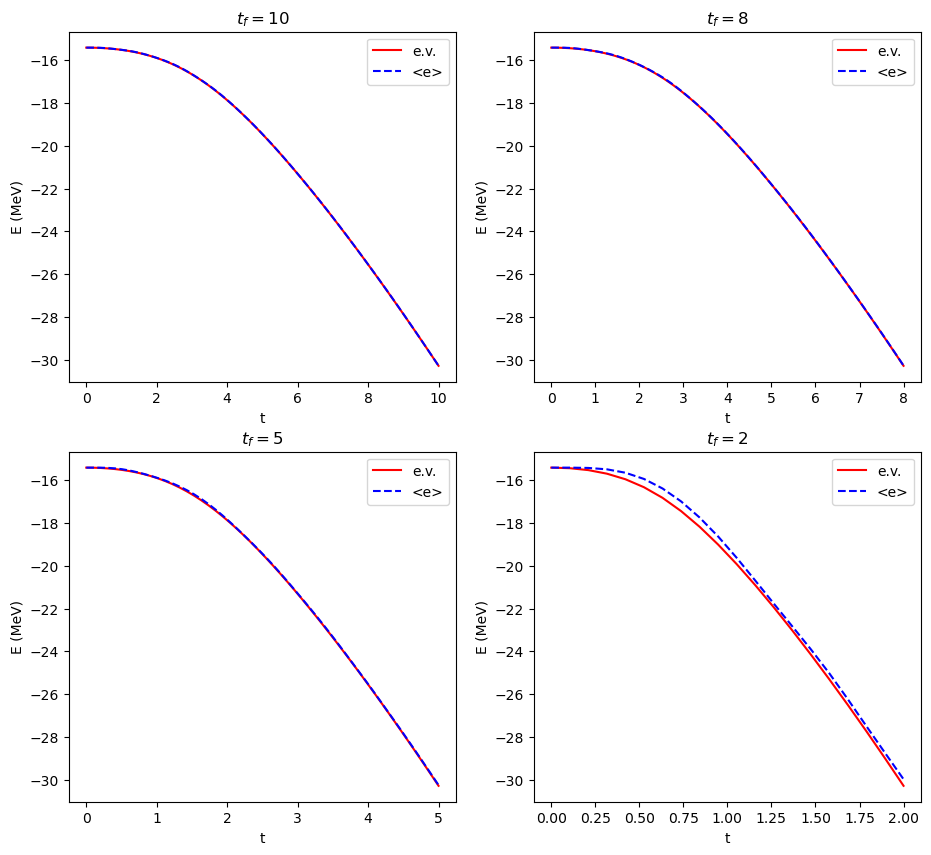

In [8]:
plt.figure('spectrum against e.v.', figsize=(11,10))
plt.subplot(221)
plt.title('$t_f = 10$')
plt.plot(time10, spectrum_arr10[:,0], 'r-', label='e.v.')
plt.plot(time10, energy_eight10, 'b--', label='<e>')
plt.xlabel('t')
plt.ylabel('E (MeV)')
plt.legend()
plt.subplot(222)
plt.title('$t_f = 8$')
plt.plot(time8, spectrum_arr8[:,0], 'r-', label='e.v.')
plt.plot(time8, energy_eight8, 'b--', label='<e>')
plt.xlabel('t')
plt.ylabel('E (MeV)')
plt.legend()
plt.subplot(223)
plt.title('$t_f = 5$')
plt.plot(time5, spectrum_arr5[:,0], 'r-', label='e.v.')
plt.plot(time5, energy_eight5, 'b--', label='<e>')
plt.xlabel('t')
plt.ylabel('E (MeV)')
plt.legend()
plt.subplot(224)
plt.title('$t_f = 2$')
plt.plot(time2, spectrum_arr2[:,0], 'r-', label='e.v.')
plt.plot(time2, energy_eight2, 'b--', label='<e>')
plt.xlabel('t')
plt.ylabel('E (MeV)')
plt.legend()



Fianlly, let's make a plot of the probabilities of population on time of the first 4 excited states for each time period

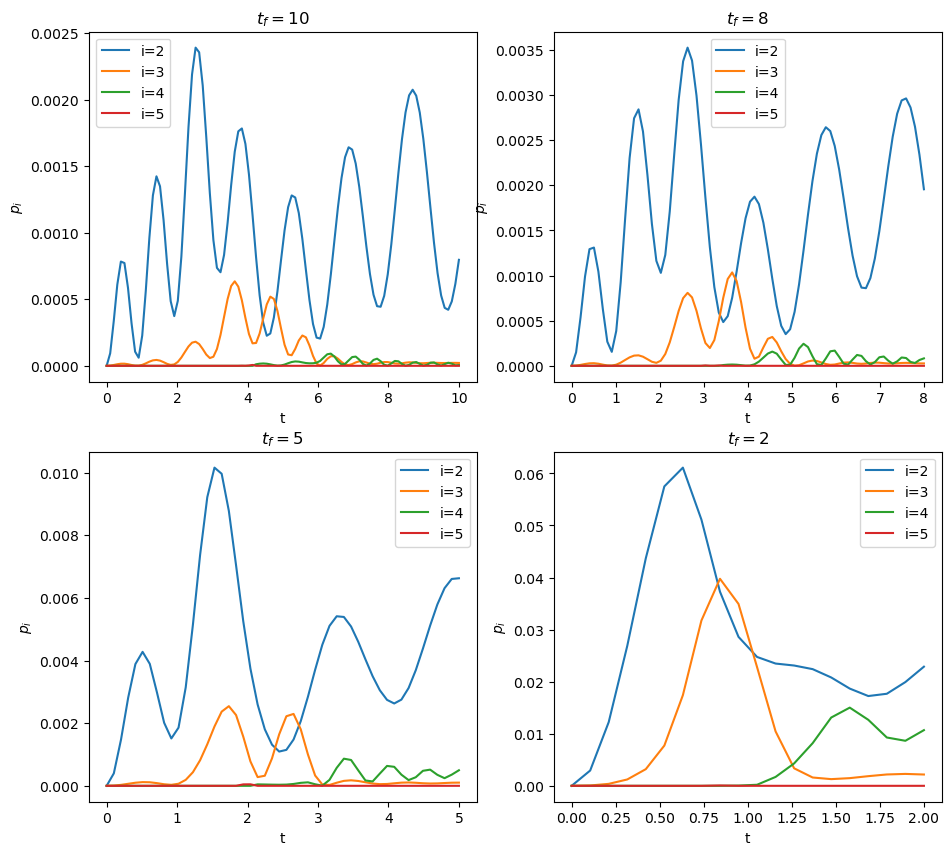

In [9]:
plt.figure('Probability of excited levels 8Be', figsize=(11,10))
plt.subplot(221)
plt.title('$t_f=10$')
plt.plot(time10, prob_eightarr10[:,0], label='i=2')
plt.plot(time10, prob_eightarr10[:,1], label='i=3')
plt.plot(time10, prob_eightarr10[:,2], label='i=4')
plt.plot(time10, prob_eightarr10[:,3], label='i=5')
plt.ylabel('$p_i$')
plt.xlabel('t')
plt.legend()
plt.subplot(222)
plt.title('$t_f=8$')
plt.plot(time8, prob_eightarr8[:,0], label='i=2')
plt.plot(time8, prob_eightarr8[:,1], label='i=3')
plt.plot(time8, prob_eightarr8[:,2], label='i=4')
plt.plot(time8, prob_eightarr8[:,3], label='i=5')
plt.ylabel('$p_i$')
plt.xlabel('t')
plt.legend()
plt.subplot(223)
plt.title('$t_f=5$')
plt.plot(time5, prob_eightarr5[:,0], label='i=2')
plt.plot(time5, prob_eightarr5[:,1], label='i=3')
plt.plot(time5, prob_eightarr5[:,2], label='i=4')
plt.plot(time5, prob_eightarr5[:,3], label='i=5')
plt.ylabel('$p_i$')
plt.xlabel('t')
plt.legend()
plt.subplot(224)
plt.title('$t_f=2$')
plt.plot(time2, prob_eightarr2[:,0], label='i=2')
plt.plot(time2, prob_eightarr2[:,1], label='i=3')
plt.plot(time2, prob_eightarr2[:,2], label='i=4')
plt.plot(time2, prob_eightarr2[:,3], label='i=5')
plt.ylabel('$p_i$')
plt.xlabel('t')
plt.legend()

Text(0, 0.5, 'F(t)')

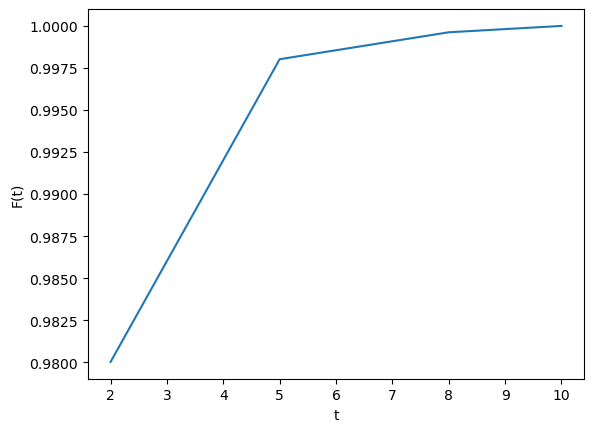

In [10]:
#  FIDELITY OVER TIME
tau = np.array([10., 8., 5., 2.])
exval = np.array([np.real(energy_eight10[tsteps-1]), np.real(energy_eight8[tsteps8-1]), 
                  np.real(energy_eight5[tsteps5-1]), np.real(energy_eight2[tsteps2-1])])
egval = np.array([spectrum_arr10[tsteps-1,0], spectrum_arr8[tsteps8-1,0], spectrum_arr5[tsteps5-1,0], spectrum_arr2[tsteps2-1,0]])
fidelity_eight = np.abs(exval*egval)**2.0
fidelity_eight = fidelity_eight / fidelity_eight.max()

plt.figure('fidelity')
plt.plot(tau, fidelity_eight)
plt.xlabel('t')
plt.ylabel('F(t)')

## $^{10}Be$

In [11]:
# 10-Be (2 protons and 4 neutrons in p-shell):
p = 2
n_ten = 4

NSM_H_ten = FermiHubbardHamiltonian(size_a=nuc_modes_per_i, size_b=nuc_modes_per_i, nparticles_a=n_ten, nparticles_b=p, 
                                symmetries=[SPS.total_M_zero]) # we force M=0 so we don't get the full manybody basis

NSM_H_ten.get_external_potential(external_potential=SPS.energies)
twobody_dict_ten, _ = get_twobody_nuclearshell_model(file_name=p_shell)

NSM_H_ten.get_twobody_interaction(twobody_dict_ten)
NSM_H_ten.get_hamiltonian() # Now we have the Target Hamiltonian ready

egs_ten, psigs = NSM_H_ten.get_spectrum(n_states=1) # just the ground state (energy in MeV's)
print(f'GS energy = {egs_ten[0]:.5} MeV')
print(NSM_H_ten.hamiltonian)

Computing the matrix, pls wait... (u_u) 



100%|██████████| 12/12 [00:01<00:00,  8.13it/s]
1424it [00:03, 405.47it/s]

GS energy = -39.453 MeV
  (0, 0)	-28.96475
  (0, 1)	1.043099999999999
  (0, 2)	1.1027499999999997
  (0, 3)	1.1027499999999997
  (0, 4)	-3.7638586855778717
  (0, 5)	1.900998549179548
  (0, 6)	-2.3986297010721485
  (0, 7)	-0.7982485491795481
  (0, 9)	1.3652289845057242
  (0, 10)	-1.7342150334467596
  (0, 12)	0.5966341818903771
  (0, 13)	1.9009985491795465
  (0, 20)	1.9009985491795485
  (0, 25)	-1.7342150334467599
  (0, 26)	0.5966341818903774
  (0, 31)	3.763858685577873
  (0, 36)	-0.7982485491795479
  (0, 37)	1.3652289845057242
  (0, 39)	1.9009985491795478
  (0, 40)	-2.3986297010721485
  (0, 41)	-3.763858685577873
  (1, 0)	1.043099999999999
  (1, 1)	-28.96475000000002
  (1, 2)	1.102750000000001
  (1, 3)	1.102749999999999
  :	:
  (49, 49)	-14.222665000000017
  (49, 50)	2.002499032786365
  (50, 20)	-2.3986297010721485
  (50, 23)	1.9009985491795474
  (50, 24)	-3.1602874999999995
  (50, 25)	0.5966341818903769
  (50, 26)	-0.8524224304885455
  (50, 27)	-1.10275
  (50, 30)	0.9007550000000002
  (

Driver Hamiltonian for $^{10}Be$

In [12]:
# We select the product state of the basis that minimizes the Hamiltonian
ini_base_el_ten = np.array([1.,1.,1.,1.,0.,0.,1.,0.,0.,1.,0.,0.])
ini_idx = NSM_H_ten._get_index(ini_base_el_ten)
psi_ini_ten = np.zeros(NSM_H_ten.hamiltonian.shape[0])
psi_ini_ten[ini_idx] = 1
print(psi_ini_ten)

# Get the external potential
ext_pot_ten = (NSM_H_ten.hamiltonian[ini_idx,ini_idx] / (p+ n_ten)) * ini_base_el_ten


# Now we get the Driver Hamiltonian
Driver_H_ten = FermiHubbardHamiltonian(size_a=nuc_modes_per_i, size_b=nuc_modes_per_i, nparticles_a=n_ten, nparticles_b=p, 
                                   symmetries=[SPS.total_M_zero])
Driver_H_ten.get_external_potential(ext_pot_ten)
Driver_H_ten.get_hamiltonian()
print(Driver_H_ten.hamiltonian)

[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0.]
  (0, 0)	-28.96475
  (1, 1)	-19.309833333333334
  (2, 2)	-19.309833333333334
  (3, 3)	-19.309833333333334
  (4, 4)	-19.309833333333334
  (5, 5)	-19.309833333333334
  (6, 6)	-19.309833333333334
  (7, 7)	-19.309833333333334
  (8, 8)	-14.482375000000001
  (9, 9)	-19.309833333333334
  (10, 10)	-19.309833333333334
  (11, 11)	-14.482375000000001
  (12, 12)	-19.309833333333334
  (13, 13)	-24.137291666666666
  (14, 14)	-14.482375000000001
  (15, 15)	-14.482375000000001
  (16, 16)	-14.482375000000001
  (17, 17)	-14.482375000000001
  (18, 18)	-14.482375000000001
  (19, 19)	-14.482375000000001
  (20, 20)	-24.137291666666666
  (21, 21)	-14.482375000000001
  (22, 22)	-14.482375000000001
  (23, 23)	-14.482375000000001
  (24, 24)	-14.482375000000001
  :	:
  (26, 26)	-19.309833333333334
  (27, 27)	-14.482375000000001
  (28, 28)	-14.482375000000001

Now we perform the adiabatic evolution on $^{10}Be$

C:\Users\alber\AppData\Local\Temp\ipykernel_104488\2383082884.py:27: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(221)


FINAL ENERGIES (in MeV)
tf=10 -> -39.44968602416995
tf=10 -> -39.44357946378561
tf=10 -> -39.43319906644147
tf=10 -> -39.10841841860056
GS energy = -39.453 MeV


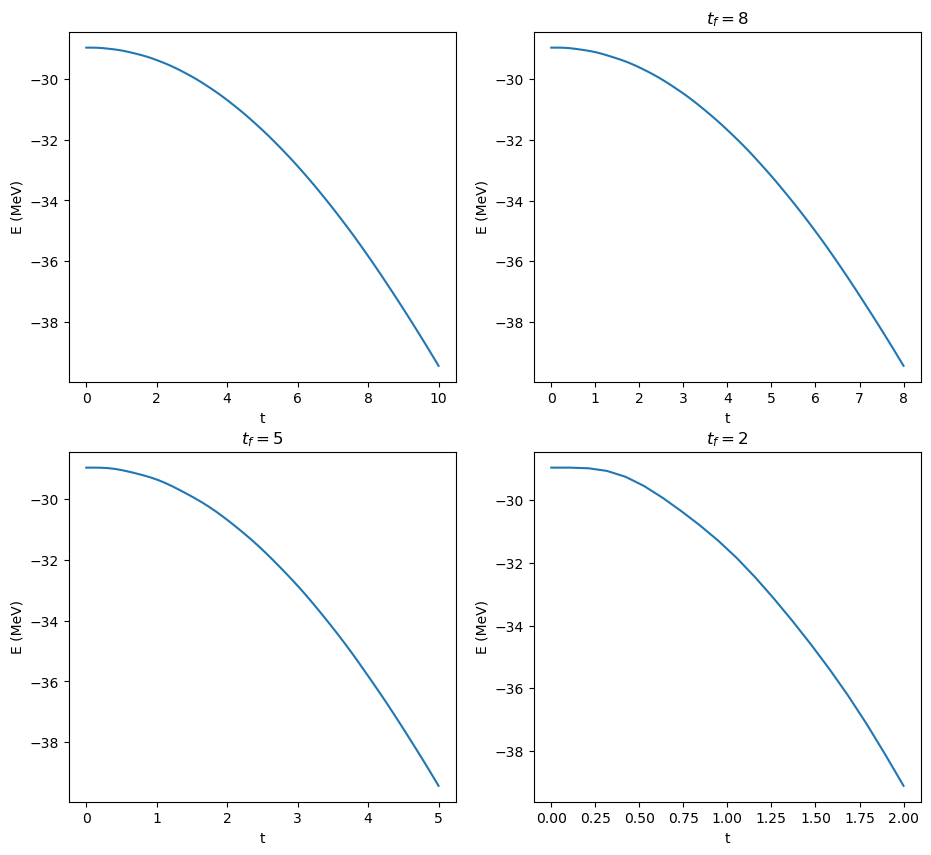

In [13]:
tf = 10
tsteps = 100
dt = tf / tsteps
time10 = np.linspace(0, tf, tsteps)

psi_ten = psi_ini_ten.copy()
energy_ten10 = []
spectrum_t_ten = []
prob_tenarr = []

for i, t in enumerate(time10):
    prob_ten = []
    H_t_ten = (1 - t/tf) * Driver_H_ten.hamiltonian + (t/tf) * NSM_H_ten.hamiltonian
    energy_ten10.append(psi_ten.conjugate().transpose().dot(H_t_ten.dot(psi_ten))) # we append <psi|H(t)|psi>
    eigval_ten, eigvec_ten = eigsh(H_t_ten, k=5, which = 'SA')
    spectrum_t_ten.append(eigval_ten)
    psi_ten = expm_multiply(-1j * dt * H_t_ten,psi_ten)
    for k in range(1,5):
        prob_ten.append(np.linalg.norm(psi_ten.conjugate().dot(eigvec_ten[:,k]))**2.0)
    prob_tenarr.append(prob_ten)
prob_tenarr10 = np.asarray(prob_tenarr)
spectrum_arr_ten10 = np.asarray(spectrum_t_ten)

# We plot the energy along time
plt.figure('10Be', figsize=(11,10))
plt.title('$t_f = 10$')
plt.subplot(221)
plt.plot(time10, energy_ten10)
plt.xlabel('t')
plt.ylabel('E (MeV)')

# Now let's perform the annealing for shorter times, also dt=0.1
# FINAL TIME -> 8
tsteps8 = 80
time8 = np.linspace(0, 8, tsteps8)
dt = 8 / tsteps8
psi_ten = psi_ini_ten.copy()
energy_ten8 = []
spectrum_t_ten = []
prob_tenarr = []

for i, t in enumerate(time8):
    prob_ten = []
    H_t_ten = (1 - t/8) * Driver_H_ten.hamiltonian + (t/8) * NSM_H_ten.hamiltonian
    energy_ten8.append(psi_ten.conjugate().transpose().dot(H_t_ten.dot(psi_ten))) # we append <psi|H(t)|psi>
    eigval_ten, eigvec_ten = eigsh(H_t_ten, k=5, which = 'SA')
    spectrum_t_ten.append(eigval_ten)
    psi_ten = expm_multiply(-1j * dt * H_t_ten,psi_ten)
    for k in range(1,5):
        prob_ten.append(np.linalg.norm(psi_ten.conjugate().dot(eigvec_ten[:,k]))**2.0)
    prob_tenarr.append(prob_ten)
prob_tenarr8 = np.asarray(prob_tenarr)
spectrum_arr_ten8 = np.asarray(spectrum_t_ten)

# We plot the energy along time
plt.subplot(222)
plt.title('$t_f = 8$')
plt.plot(time8, energy_ten8)
plt.xlabel('t')
plt.ylabel('E (MeV)')

# FINAL TIME -> 5
tsteps5 = 50
time5 = np.linspace(0, 5, tsteps5)
dt = 5 / tsteps5
psi_ten = psi_ini_ten.copy()
energy_ten5 = []
spectrum_t_ten = []
prob_tenarr = []

for i, t in enumerate(time5):
    prob_ten = []
    H_t_ten = (1 - t/5) * Driver_H_ten.hamiltonian + (t/5) * NSM_H_ten.hamiltonian
    energy_ten5.append(psi_ten.conjugate().transpose().dot(H_t_ten.dot(psi_ten))) # we append <psi|H(t)|psi>
    eigval_ten, eigvec_ten = eigsh(H_t_ten, k=5, which = 'SA')
    spectrum_t_ten.append(eigval_ten)
    psi_ten = expm_multiply(-1j * dt * H_t_ten,psi_ten)
    for k in range(1,5):
        prob_ten.append(np.linalg.norm(psi_ten.conjugate().dot(eigvec_ten[:,k]))**2.0)
    prob_tenarr.append(prob_ten)
prob_tenarr5 = np.asarray(prob_tenarr)
spectrum_arr_ten5 = np.asarray(spectrum_t_ten)

# We plot the energy along time
plt.subplot(223)
plt.title('$t_f = 5$')
plt.plot(time5, energy_ten5)
plt.xlabel('t')
plt.ylabel('E (MeV)')

# FINAL TIME -> 2
tsteps2 = 20
time2 = np.linspace(0, 2, tsteps2)
dt = 2 / tsteps2
psi_ten = psi_ini_ten.copy()
energy_ten2 = []
spectrum_t_ten = []
prob_tenarr = []

for i, t in enumerate(time2):
    prob_ten = []
    H_t_ten = (1 - t/2) * Driver_H_ten.hamiltonian + (t/2) * NSM_H_ten.hamiltonian
    energy_ten2.append(psi_ten.conjugate().transpose().dot(H_t_ten.dot(psi_ten))) # we append <psi|H(t)|psi>
    eigval_ten, eigvec_ten = eigsh(H_t_ten, k=5, which = 'SA')
    spectrum_t_ten.append(eigval_ten)
    psi_ten = expm_multiply(-1j * dt * H_t_ten,psi_ten)
    for k in range(1,5):
        prob_ten.append(np.linalg.norm(psi_ten.conjugate().dot(eigvec_ten[:,k]))**2.0)
    prob_tenarr.append(prob_ten)
prob_tenarr2 = np.asarray(prob_tenarr)
spectrum_arr_ten2 = np.asarray(spectrum_t_ten)

# We plot the energy along time
plt.subplot(224)
plt.title('$t_f = 2$')
plt.plot(time2, energy_ten2)
plt.xlabel('t')
plt.ylabel('E (MeV)')

# Let's print the final energies, compared to the GS
print('FINAL ENERGIES (in MeV)')
print('tf=10 ->', np.real(energy_ten10[tsteps-1]))
print('tf=10 ->', np.real(energy_ten8[tsteps8-1]))
print('tf=10 ->', np.real(energy_ten5[tsteps5-1]))
print('tf=10 ->', np.real(energy_ten2[tsteps2-1]))
print(f'GS energy = {egs_ten[0]:.5} MeV')

We see that the energy at the end of the process is the same as the GS energy of the NSM $\rightarrow$ well executed!

Finally, let's compare the plot above with part of the spectrum of $H(t)$

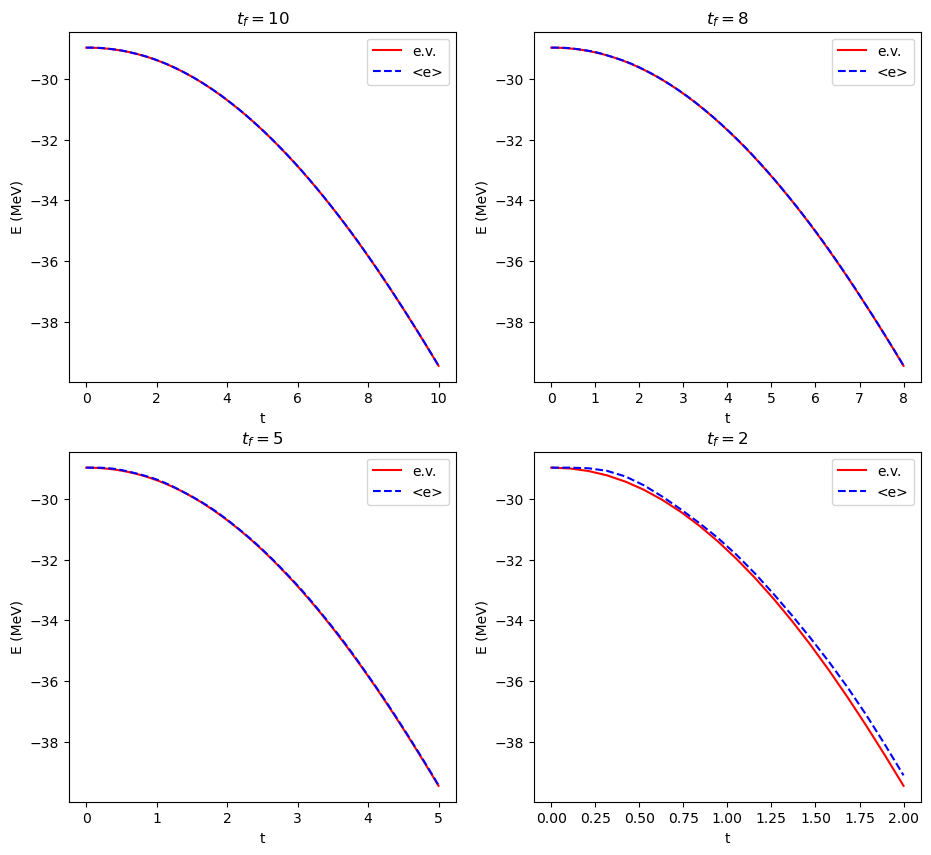

In [14]:
plt.figure('spectrum comp. 10Be', figsize=(11,10))
plt.subplot(221)
plt.title('$t_f = 10$')
plt.plot(time10, spectrum_arr_ten10[:,0], 'r-', label='e.v.')
plt.plot(time10, energy_ten10, 'b--', label='<e>')
plt.xlabel('t')
plt.ylabel('E (MeV)')
plt.legend()
plt.subplot(222)
plt.title('$t_f = 8$')
plt.plot(time8, spectrum_arr_ten8[:,0], 'r-', label='e.v.')
plt.plot(time8, energy_ten8, 'b--', label='<e>')
plt.xlabel('t')
plt.ylabel('E (MeV)')
plt.legend()
plt.subplot(223)
plt.title('$t_f = 5$')
plt.plot(time5, spectrum_arr_ten5[:,0], 'r-', label='e.v.')
plt.plot(time5, energy_ten5, 'b--', label='<e>')
plt.xlabel('t')
plt.ylabel('E (MeV)')
plt.legend()
plt.subplot(224)
plt.title('$t_f = 2$')
plt.plot(time2, spectrum_arr_ten2[:,0], 'r-', label='e.v.')
plt.plot(time2, energy_ten2, 'b--', label='<e>')
plt.xlabel('t')
plt.ylabel('E (MeV)')
plt.legend()

Fianlly, let's make a plot of the probabilities of population on time of the first 4 excited states for each time period

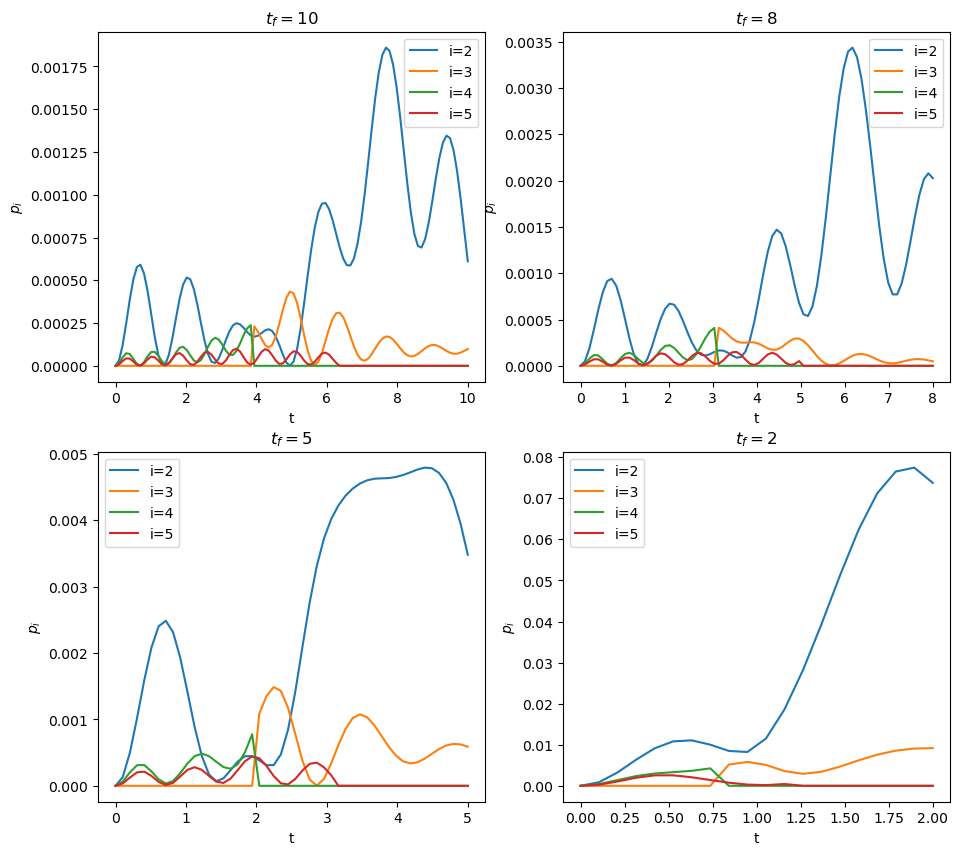

In [15]:
plt.figure('Probability of excited levels 8Be', figsize=(11,10))
plt.subplot(221)
plt.title('$t_f = 10$')
plt.plot(time10, prob_tenarr10[:,0], label = 'i=2')
plt.plot(time10, prob_tenarr10[:,1], label = 'i=3')
plt.plot(time10, prob_tenarr10[:,2], label = 'i=4')
plt.plot(time10, prob_tenarr10[:,3], label = 'i=5')
plt.xlabel('t')
plt.ylabel('$p_i$')
plt.legend()
plt.subplot(222)
plt.title('$t_f = 8$')
plt.plot(time8, prob_tenarr8[:,0], label = 'i=2')
plt.plot(time8, prob_tenarr8[:,1], label = 'i=3')
plt.plot(time8, prob_tenarr8[:,2], label = 'i=4')
plt.plot(time8, prob_tenarr8[:,3], label = 'i=5')
plt.xlabel('t')
plt.ylabel('$p_i$')
plt.legend()
plt.subplot(223)
plt.title('$t_f = 5$')
plt.plot(time5, prob_tenarr5[:,0], label = 'i=2')
plt.plot(time5, prob_tenarr5[:,1], label = 'i=3')
plt.plot(time5, prob_tenarr5[:,2], label = 'i=4')
plt.plot(time5, prob_tenarr5[:,3], label = 'i=5')
plt.xlabel('t')
plt.ylabel('$p_i$')
plt.legend()
plt.subplot(224)
plt.title('$t_f = 2$')
plt.plot(time2, prob_tenarr2[:,0], label = 'i=2')
plt.plot(time2, prob_tenarr2[:,1], label = 'i=3')
plt.plot(time2, prob_tenarr2[:,2], label = 'i=4')
plt.plot(time2, prob_tenarr2[:,3], label = 'i=5')
plt.xlabel('t')
plt.ylabel('$p_i$')
plt.legend()

## $^{12}Be$

In [16]:
# 12-Be (2 protons and 6 neutrons in p-shell):
p = 2
n_twelve = 6

NSM_H_twelve = FermiHubbardHamiltonian(size_a=nuc_modes_per_i, size_b=nuc_modes_per_i, nparticles_a=n_twelve, nparticles_b=p, 
                                symmetries=[SPS.total_M_zero]) # we force M=0 so we don't get the full manybody basis

NSM_H_twelve.get_external_potential(external_potential=SPS.energies)
twobody_dict_twelve, _ = get_twobody_nuclearshell_model(file_name=p_shell)

NSM_H_twelve.get_twobody_interaction(twobody_dict_twelve)
NSM_H_twelve.get_hamiltonian() # Now we have the Target Hamiltonian ready

egs_twelve, psigs = NSM_H_twelve.get_spectrum(n_states=1) # just the ground state (energy in MeV's)
print(f'GS energy = {egs_twelve[0]:.5} MeV')
print(NSM_H_twelve.hamiltonian)

Computing the matrix, pls wait... (u_u) 



100%|██████████| 12/12 [00:01<00:00,  8.22it/s]
1424it [00:01, 766.77it/s]


GS energy = -41.221 MeV
  (0, 0)	-38.16192500000004
  (0, 1)	1.043099999999999
  (0, 2)	1.1027499999999997
  (0, 3)	1.1027499999999997
  (0, 4)	-3.7638586855778717
  (1, 0)	1.043099999999999
  (1, 1)	-38.16192500000005
  (1, 2)	1.102750000000001
  (1, 3)	1.1027499999999992
  (1, 4)	3.7638586855778717
  (2, 0)	1.1027499999999997
  (2, 1)	1.102750000000001
  (2, 2)	-32.12878750000006
  (2, 3)	-1.0018999999999996
  (2, 4)	3.608224830031759e-16
  (3, 0)	1.1027499999999997
  (3, 1)	1.1027499999999992
  (3, 2)	-1.0018999999999996
  (3, 3)	-32.128787500000044
  (3, 4)	-1.3322676295501878e-15
  (4, 0)	-3.7638586855778717
  (4, 1)	3.7638586855778717
  (4, 2)	3.608224830031759e-16
  (4, 3)	-1.3322676295501878e-15
  (4, 4)	-27.170250000000028


Driver Hamiltonian for $^{12}Be$

In [17]:
# We select the product state of the basis that minimizes the Hamiltonian
ini_base_el_twelve = np.array([1.,1.,1.,1.,1.,1.,
                               1.,0.,0.,1.,0.,0.])
ini_idx = NSM_H_twelve._get_index(ini_base_el_twelve)
psi_ini_twelve = np.zeros(NSM_H_twelve.hamiltonian.shape[0])
psi_ini_twelve[ini_idx] = 1
print(psi_ini_twelve)

# Get the external potential
ext_pot_twelve = (NSM_H_twelve.hamiltonian[ini_idx,ini_idx] / (p + n_twelve)) * ini_base_el_twelve

# Now we get the Driver Hamiltonian
Driver_H_twelve = FermiHubbardHamiltonian(size_a=nuc_modes_per_i, size_b=nuc_modes_per_i, nparticles_a=n_twelve, nparticles_b=p, 
                                   symmetries=[SPS.total_M_zero])
Driver_H_twelve.get_external_potential(ext_pot_twelve)
Driver_H_twelve.get_hamiltonian()
print(Driver_H_twelve.hamiltonian)

[1. 0. 0. 0. 0.]
  (0, 0)	-38.161925000000046
  (1, 1)	-28.621443750000033
  (2, 2)	-28.621443750000033
  (3, 3)	-28.621443750000033
  (4, 4)	-28.621443750000033


Now we perform the adiabatic evolution on $^{12}Be$

FINAL ENERGIES (in MeV)
tf=10 -> -41.21572327153493
tf=10 -> -41.21108116176333
tf=10 -> -41.18481302383904
tf=10 -> -40.842476572848256
GS energy = -41.221 MeV


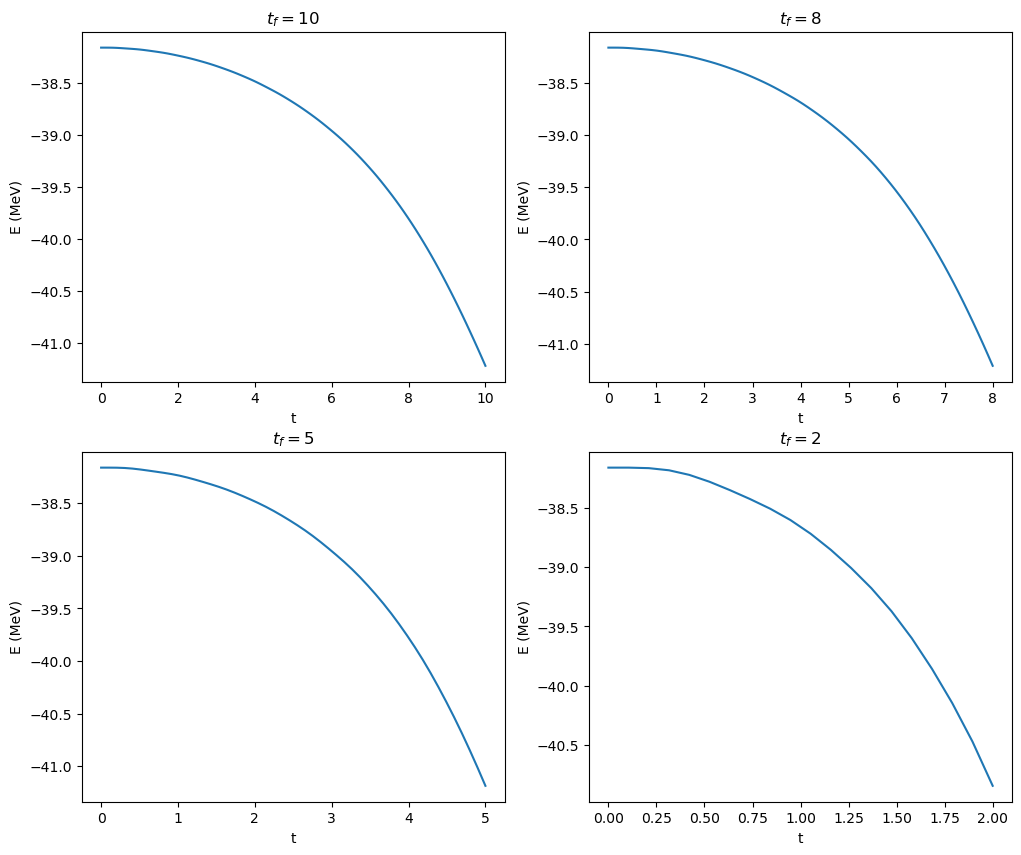

In [18]:
tf = 10
tsteps = 100
dt = tf / tsteps
time10 = np.linspace(0, tf, tsteps)

psi_twelve = psi_ini_twelve.copy()
energy_twelve10 = []
spectrum_t_twelve = []
prob_twelvearr = []

for i, t in enumerate(time10):
    prob_twelve = []
    H_t_twelve = (1 - t/tf) * Driver_H_twelve.hamiltonian + (t/tf) * NSM_H_twelve.hamiltonian
    energy_twelve10.append(psi_twelve.conjugate().transpose().dot(H_t_twelve.dot(psi_twelve))) # we append <psi|H(t)|psi>
    eigval_twelve, eigvec_twelve = eigsh(H_t_twelve, k=4, which = 'SA') #!!!!! WHY 5 NOT ADMISSIBLE??? (ONLY 3 EXCITED STATES)
    spectrum_t_twelve.append(eigval_twelve)
    psi_twelve = expm_multiply(-1j * dt * H_t_twelve,psi_twelve)
    for k in range(1,4):
        prob_twelve.append(np.linalg.norm(psi_twelve.conjugate().dot(eigvec_twelve[:,k]))**2.0)
    prob_twelvearr.append(prob_twelve)
prob_twelvearr10 = np.asarray(prob_twelvearr)
spectrum_arr_twelve10 = np.asarray(spectrum_t_twelve)

# We plot the energy along time
plt.figure('12Be', figsize=(12,10))
plt.subplot(221)
plt.title('$t_f = 10$')
plt.plot(time10, energy_twelve10)
plt.xlabel('t')
plt.ylabel('E (MeV)')

# Now let's perform the annealing for shorter times, also dt=0.1
# FINAL TIME -> 8
tsteps8 = 80
time8 = np.linspace(0, 8, tsteps8)
dt = 8/tsteps8
psi_twelve = psi_ini_twelve.copy()
energy_twelve8 = []
spectrum_t_twelve = []
prob_twelvearr = []

for i, t in enumerate(time8):
    prob_twelve = []
    H_t_twelve = (1 - t/8) * Driver_H_twelve.hamiltonian + (t/8) * NSM_H_twelve.hamiltonian
    energy_twelve8.append(psi_twelve.conjugate().transpose().dot(H_t_twelve.dot(psi_twelve))) # we append <psi|H(t)|psi>
    eigval_twelve, eigvec_twelve = eigsh(H_t_twelve, k=4, which = 'SA') 
    spectrum_t_twelve.append(eigval_twelve)
    psi_twelve = expm_multiply(-1j * dt * H_t_twelve,psi_twelve)
    for k in range(1,4):
        prob_twelve.append(np.linalg.norm(psi_twelve.conjugate().dot(eigvec_twelve[:,k]))**2.0)
    prob_twelvearr.append(prob_twelve)
prob_twelvearr8 = np.asarray(prob_twelvearr)
spectrum_arr_twelve8 = np.asarray(spectrum_t_twelve)

# We plot the energy along time
plt.subplot(222)
plt.title('$t_f = 8$')
plt.plot(time8, energy_twelve8)
plt.xlabel('t')
plt.ylabel('E (MeV)')

# FINAL TIME -> 5
tsteps5 = 50
time5 = np.linspace(0, 5, tsteps5)
dt = 5/tsteps5
psi_twelve = psi_ini_twelve.copy()
energy_twelve5 = []
spectrum_t_twelve = []
prob_twelvearr = []

for i, t in enumerate(time5):
    prob_twelve = []
    H_t_twelve = (1 - t/5) * Driver_H_twelve.hamiltonian + (t/5) * NSM_H_twelve.hamiltonian
    energy_twelve5.append(psi_twelve.conjugate().transpose().dot(H_t_twelve.dot(psi_twelve))) # we append <psi|H(t)|psi>
    eigval_twelve, eigvec_twelve = eigsh(H_t_twelve, k=4, which = 'SA') 
    spectrum_t_twelve.append(eigval_twelve)
    psi_twelve = expm_multiply(-1j * dt * H_t_twelve,psi_twelve)
    for k in range(1,4):
        prob_twelve.append(np.linalg.norm(psi_twelve.conjugate().dot(eigvec_twelve[:,k]))**2.0)
    prob_twelvearr.append(prob_twelve)
prob_twelvearr5 = np.asarray(prob_twelvearr)
spectrum_arr_twelve5 = np.asarray(spectrum_t_twelve)

# We plot the energy along time
plt.subplot(223)
plt.title('$t_f = 5$')
plt.plot(time5, energy_twelve5)
plt.xlabel('t')
plt.ylabel('E (MeV)')

# FINAL TIME -> 2
tsteps2 = 20
time2 = np.linspace(0, 2, tsteps2)
dt = 2/tsteps2
psi_twelve = psi_ini_twelve.copy()
energy_twelve2 = []
spectrum_t_twelve = []
prob_twelvearr = []

for i, t in enumerate(time2):
    prob_twelve = []
    H_t_twelve = (1 - t/2) * Driver_H_twelve.hamiltonian + (t/2) * NSM_H_twelve.hamiltonian
    energy_twelve2.append(psi_twelve.conjugate().transpose().dot(H_t_twelve.dot(psi_twelve))) # we append <psi|H(t)|psi>
    eigval_twelve, eigvec_twelve = eigsh(H_t_twelve, k=4, which = 'SA') 
    spectrum_t_twelve.append(eigval_twelve)
    psi_twelve = expm_multiply(-1j * dt * H_t_twelve,psi_twelve)
    for k in range(1,4):
        prob_twelve.append(np.linalg.norm(psi_twelve.conjugate().dot(eigvec_twelve[:,k]))**2.0)
    prob_twelvearr.append(prob_twelve)
prob_twelvearr2 = np.asarray(prob_twelvearr)
spectrum_arr_twelve2 = np.asarray(spectrum_t_twelve)

# We plot the energy along time
plt.subplot(224)
plt.title('$t_f = 2$')
plt.plot(time2, energy_twelve2)
plt.xlabel('t')
plt.ylabel('E (MeV)')

# Let's print the final energies, compared to the GS
print('FINAL ENERGIES (in MeV)')
print('tf=10 ->', np.real(energy_twelve10[tsteps-1]))
print('tf=10 ->', np.real(energy_twelve8[tsteps8-1]))
print('tf=10 ->', np.real(energy_twelve5[tsteps5-1]))
print('tf=10 ->', np.real(energy_twelve2[tsteps2-1]))
print(f'GS energy = {egs_twelve[0]:.5} MeV')

We see that the energy at the end of the process is approx. the same as the GS energy of the NSM $\rightarrow$ well executed!

Finally, let's compare the plot above with part of the spectrum of $H(t)$

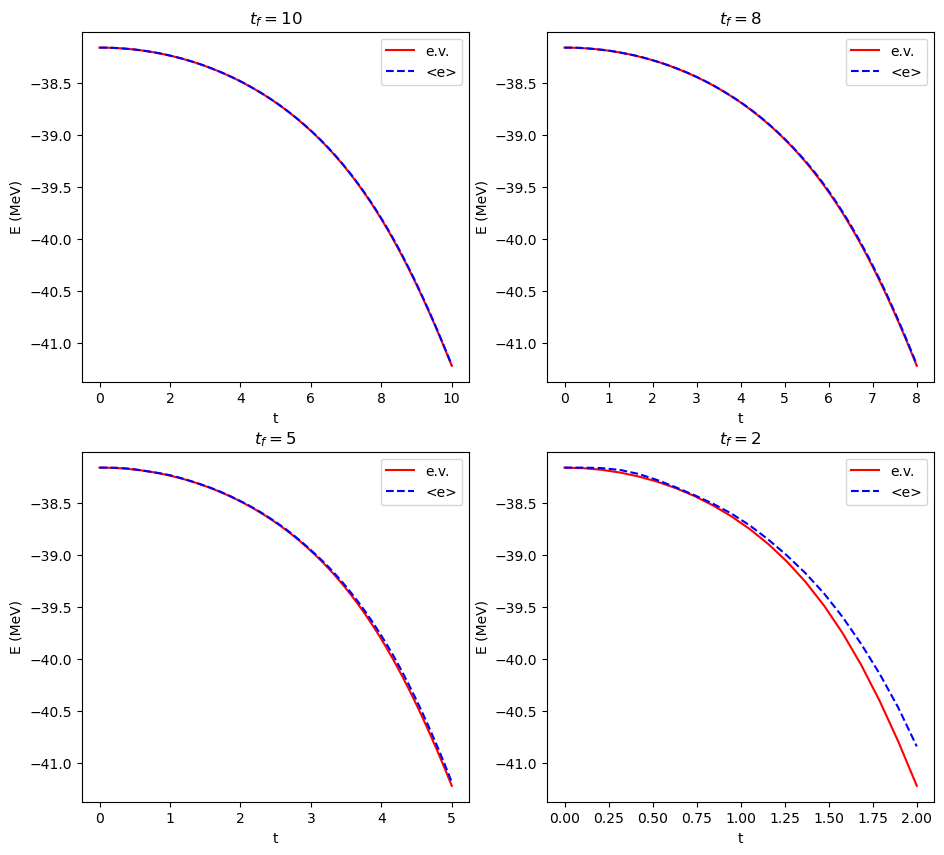

In [19]:
plt.figure(figsize=(11,10))
plt.subplot(221)
plt.title('$t_f = 10$')
plt.plot(time10, np.real(spectrum_arr_twelve10[:,0]), 'r-', label='e.v.')
plt.plot(time10, np.real(energy_twelve10), 'b--', label='<e>')
plt.xlabel('t')
plt.ylabel('E (MeV)')
plt.legend()
plt.subplot(222)
plt.title('$t_f = 8$')
plt.plot(time8, np.real(spectrum_arr_twelve8[:,0]), 'r-', label='e.v.')
plt.plot(time8, np.real(energy_twelve8), 'b--', label='<e>')
plt.xlabel('t')
plt.ylabel('E (MeV)')
plt.legend()
plt.subplot(223)
plt.title('$t_f = 5$')
plt.plot(time5, np.real(spectrum_arr_twelve5[:,0]), 'r-', label='e.v.')
plt.plot(time5, np.real(energy_twelve5), 'b--', label='<e>')
plt.xlabel('t')
plt.ylabel('E (MeV)')
plt.legend()
plt.subplot(224)
plt.title('$t_f = 2$')
plt.plot(time2, np.real(spectrum_arr_twelve2[:,0]), 'r-', label='e.v.')
plt.plot(time2, np.real(energy_twelve2), 'b--', label='<e>')
plt.xlabel('t')
plt.ylabel('E (MeV)')
plt.legend()

Fianlly, let's make a plot of the probabilities of population on time of the first 4 excited states for each time period

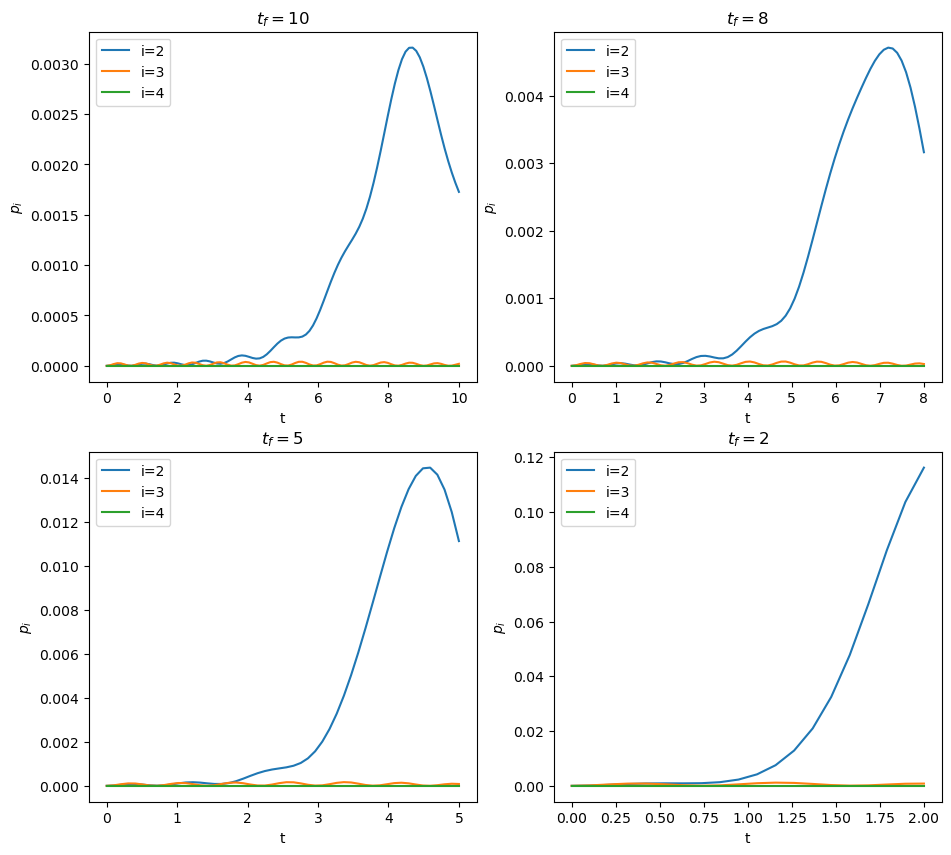

In [20]:
plt.figure(figsize=(11,10))
plt.subplot(221)
plt.title('$t_f = 10$')
plt.plot(time10, prob_twelvearr10[:,0], label='i=2')
plt.plot(time10, prob_twelvearr10[:,1], label='i=3')
plt.plot(time10, prob_twelvearr10[:,2], label='i=4')
plt.ylabel('$p_i$')
plt.xlabel('t')
plt.legend()
plt.subplot(222)
plt.title('$t_f = 8$')
plt.plot(time8, prob_twelvearr8[:,0], label='i=2')
plt.plot(time8, prob_twelvearr8[:,1], label='i=3')
plt.plot(time8, prob_twelvearr8[:,2], label='i=4')
plt.ylabel('$p_i$')
plt.xlabel('t')
plt.legend()
plt.subplot(223)
plt.title('$t_f = 5$')
plt.plot(time5, prob_twelvearr5[:,0], label='i=2')
plt.plot(time5, prob_twelvearr5[:,1], label='i=3')
plt.plot(time5, prob_twelvearr5[:,2], label='i=4')
plt.ylabel('$p_i$')
plt.xlabel('t')
plt.legend()
plt.subplot(224)
plt.title('$t_f = 2$')
plt.plot(time2, prob_twelvearr2[:,0], label='i=2')
plt.plot(time2, prob_twelvearr2[:,1], label='i=3')
plt.plot(time2, prob_twelvearr2[:,2], label='i=4')
plt.ylabel('$p_i$')
plt.xlabel('t')
plt.legend()

# $^{12}C$

In [21]:
# 12-C, 4 protons and 4 neutrons in the p-shell
p = 4
n = 4

NSM_H_c = FermiHubbardHamiltonian(size_a=nuc_modes_per_i, size_b=nuc_modes_per_i, nparticles_a=n, nparticles_b=p, 
                                symmetries=[SPS.total_M_zero]) # we force M=0 so we don't get the full manybody basis
# Also, I changed Ema's code where a was neutrons and b protons, since they're just numbers (and the same in this case)

NSM_H_c.get_external_potential(external_potential=SPS.energies)
twobody_dict_c, _ = get_twobody_nuclearshell_model(file_name=p_shell)

NSM_H_c.get_twobody_interaction(twobody_dict_c)
NSM_H_c.get_hamiltonian() # Now we have the Target Hamiltonian ready

egs_c, psigs = NSM_H_c.get_spectrum(n_states=1) # just the ground state (energy in MeV's)
print(f'GS energy = {egs_c[0]:.5} MeV')
print(NSM_H_c.hamiltonian)

Computing the matrix, pls wait... (u_u) 



100%|██████████| 12/12 [00:01<00:00,  8.22it/s]
1424it [00:02, 499.29it/s]


GS energy = -71.099 MeV
  (0, 0)	-61.06530000000002
  (0, 1)	-1.7763568394002505e-15
  (0, 2)	1.3322676295501878e-15
  (0, 3)	3.7638586855778717
  (0, 4)	-3.7638586855778717
  (0, 5)	-2.3986297010721485
  (0, 7)	0.5966341818903775
  (0, 8)	1.3652289845057242
  (0, 10)	2.054162795550007
  (0, 11)	0.5966341818903771
  (0, 13)	-1.4432899320127035e-15
  (0, 14)	-0.6889338110442831
  (0, 15)	-1.7096958900278656
  (0, 20)	6.106226635438361e-16
  (0, 21)	-1.7096958900278656
  (0, 22)	-0.6889338110442829
  (0, 25)	0.5966341818903774
  (0, 26)	2.054162795550007
  (0, 31)	3.763858685577873
  (0, 36)	1.3652289845057242
  (0, 37)	0.5966341818903769
  (0, 39)	-2.3986297010721485
  (0, 41)	-3.763858685577873
  (1, 0)	-1.7763568394002505e-15
  (1, 1)	-53.77850000000001
  :	:
  (49, 49)	-40.76367500000005
  (49, 50)	-2.002499032786365
  (50, 21)	-2.3986297010721485
  (50, 23)	1.9009985491795478
  (50, 24)	-1.9009985491795474
  (50, 25)	0.5966341818903769
  (50, 26)	1.3652289845057242
  (50, 27)	-0.175

Driver Hamiltonian for $^{12}C$

In [22]:
ini_base_el_c = np.array([1.,1.,1.,1.,0.,0.,1.,1.,1.,1.,0.,0.])
ini_idx = NSM_H_c._get_index(ini_base_el_c)
psi_ini_c = np.zeros(NSM_H_c.hamiltonian.shape[0])
psi_ini_c[ini_idx] = 1
print(psi_ini_c)
print(ini_base_el_c)

# Get the external potential
ext_pot_c = (NSM_H_c.hamiltonian[ini_idx,ini_idx] / (p+ n)) * ini_base_el_c

# Now we get the Driver Hamiltonian
Driver_H_c = FermiHubbardHamiltonian(size_a=nuc_modes_per_i, size_b=nuc_modes_per_i, nparticles_a=n, nparticles_b=p, 
                                   symmetries=[SPS.total_M_zero])
Driver_H_c.get_external_potential(ext_pot_c)
Driver_H_c.get_hamiltonian()
print(Driver_H_c.hamiltonian)

[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0.]
[1. 1. 1. 1. 0. 0. 1. 1. 1. 1. 0. 0.]
  (0, 0)	-61.06530000000003
  (1, 1)	-53.432137500000024
  (2, 2)	-53.432137500000024
  (3, 3)	-45.79897500000002
  (4, 4)	-45.79897500000002
  (5, 5)	-45.79897500000002
  (6, 6)	-38.165812500000015
  (7, 7)	-45.79897500000002
  (8, 8)	-45.79897500000002
  (9, 9)	-38.165812500000015
  (10, 10)	-45.79897500000002
  (11, 11)	-45.79897500000002
  (12, 12)	-38.165812500000015
  (13, 13)	-53.432137500000024
  (14, 14)	-45.79897500000002
  (15, 15)	-45.79897500000002
  (16, 16)	-38.165812500000015
  (17, 17)	-38.165812500000015
  (18, 18)	-38.165812500000015
  (19, 19)	-30.53265000000001
  (20, 20)	-53.432137500000024
  (21, 21)	-45.79897500000002
  (22, 22)	-45.79897500000002
  (23, 23)	-38.165812500000015
  (24, 24)	-38.165812500000015
  :	:
  (26, 26)	-45.79897500000002
  (27, 27)	-38.165812500000

Now we perform the adiabatic evolution on $^{12}C$

FINAL ENERGIES (in MeV)
tf=10 -> -71.09862967242067
tf=10 -> -71.09765905678206
tf=10 -> -71.0954551230334
tf=10 -> -71.0896134259077
GS energy = -71.099 MeV


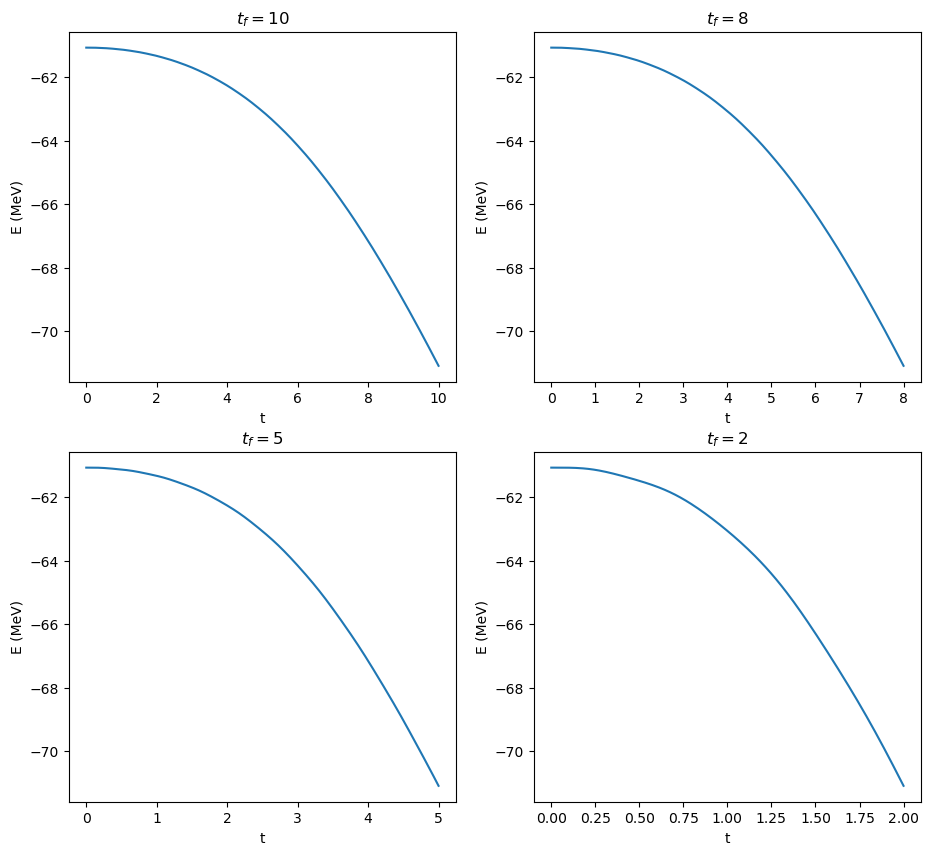

In [23]:
tf = 10
tsteps = 1000
dt = tf / tsteps
time10 = np.linspace(0, tf, tsteps)

psi_c = psi_ini_c.copy()
energy_c10 = []
spectrum_t_c = []
prob_carr = []

for i, t in enumerate(time10):
    prob_c = []
    H_t_c = (1 - t/tf) * Driver_H_c.hamiltonian + (t/tf) * NSM_H_c.hamiltonian
    energy_c10.append(psi_c.conjugate().transpose().dot(H_t_c.dot(psi_c))) # we append <psi|H(t)|psi>
    eigval_c, eigvec_c = eigsh(H_t_c, k=5, which = 'SA') 
    spectrum_t_c.append(eigval_c)
    psi_c = expm_multiply(-1j * dt * H_t_c,psi_c)
    for k in range(1,5):
        prob_c.append(np.linalg.norm(psi_c.conjugate().dot(eigvec_c[:,k]))**2.0)
    prob_carr.append(prob_c)
prob_carr10 = np.asarray(prob_carr)
spectrum_arr_c10 = np.asarray(spectrum_t_c)

# We plot the energy along time
plt.figure('12C', figsize=(11,10))
plt.subplot(221)
plt.title('$t_f = 10$')
plt.plot(time10, energy_c10)
plt.xlabel('t')
plt.ylabel('E (MeV)')

# Now let's perform the annealing for shorter times, also dt=0.01
# FINAL TIME -> 8
tsteps8 = 800
dt = 8 / tsteps8
time8 = np.linspace(0, 8, tsteps8)

psi_c = psi_ini_c.copy()
energy_c8 = []
spectrum_t_c = []
prob_carr = []

for i, t in enumerate(time8):
    prob_c = []
    H_t_c = (1 - t/8) * Driver_H_c.hamiltonian + (t/8) * NSM_H_c.hamiltonian
    energy_c8.append(psi_c.conjugate().transpose().dot(H_t_c.dot(psi_c))) # we append <psi|H(t)|psi>
    eigval_c, eigvec_c = eigsh(H_t_c, k=5, which = 'SA') 
    spectrum_t_c.append(eigval_c)
    psi_c = expm_multiply(-1j * dt * H_t_c,psi_c)
    for k in range(1,5):
        prob_c.append(np.linalg.norm(psi_c.conjugate().dot(eigvec_c[:,k]))**2.0)
    prob_carr.append(prob_c)
prob_carr8 = np.asarray(prob_carr)
spectrum_arr_c8 = np.asarray(spectrum_t_c)

# We plot the energy along time
plt.subplot(222)
plt.title('$t_f = 8$')
plt.plot(time8, energy_c8)
plt.xlabel('t')
plt.ylabel('E (MeV)')

# FINAL TIME -> 5
tsteps5 = 500
dt = 5 / tsteps5
time5 = np.linspace(0, 5, tsteps5)

psi_c = psi_ini_c.copy()
energy_c5 = []
spectrum_t_c = []
prob_carr = []

for i, t in enumerate(time5):
    prob_c = []
    H_t_c = (1 - t/5) * Driver_H_c.hamiltonian + (t/5) * NSM_H_c.hamiltonian
    energy_c5.append(psi_c.conjugate().transpose().dot(H_t_c.dot(psi_c))) # we append <psi|H(t)|psi>
    eigval_c, eigvec_c = eigsh(H_t_c, k=5, which = 'SA') 
    spectrum_t_c.append(eigval_c)
    psi_c = expm_multiply(-1j * dt * H_t_c,psi_c)
    for k in range(1,5):
        prob_c.append(np.linalg.norm(psi_c.conjugate().dot(eigvec_c[:,k]))**2.0)
    prob_carr.append(prob_c)
prob_carr5 = np.asarray(prob_carr)
spectrum_arr_c5 = np.asarray(spectrum_t_c)

# We plot the energy along time
plt.subplot(223)
plt.title('$t_f = 5$')
plt.plot(time5, energy_c5)
plt.xlabel('t')
plt.ylabel('E (MeV)')

# FINAL TIME -> 2
tsteps2 = 200
dt = 2 / tsteps2
time2 = np.linspace(0, 2, tsteps2)

psi_c = psi_ini_c.copy()
energy_c2 = []
spectrum_t_c = []
prob_carr = []

for i, t in enumerate(time2):
    prob_c = []
    H_t_c = (1 - t/2) * Driver_H_c.hamiltonian + (t/2) * NSM_H_c.hamiltonian
    energy_c2.append(psi_c.conjugate().transpose().dot(H_t_c.dot(psi_c))) # we append <psi|H(t)|psi>
    eigval_c, eigvec_c = eigsh(H_t_c, k=5, which = 'SA') 
    spectrum_t_c.append(eigval_c)
    psi_c = expm_multiply(-1j * dt * H_t_c,psi_c)
    for k in range(1,5):
        prob_c.append(np.linalg.norm(psi_c.conjugate().dot(eigvec_c[:,k]))**2.0)
    prob_carr.append(prob_c)
prob_carr2 = np.asarray(prob_carr)
spectrum_arr_c2 = np.asarray(spectrum_t_c)

# We plot the energy along time
plt.subplot(224)
plt.title('$t_f = 2$')
plt.plot(time2, energy_c2)
plt.xlabel('t')
plt.ylabel('E (MeV)')

# Let's print the final energies compared to the GS
print('FINAL ENERGIES (in MeV)')
print('tf=10 ->', np.real(energy_c10[tsteps-1]))
print('tf=10 ->', np.real(energy_c8[tsteps8-1]))
print('tf=10 ->', np.real(energy_c5[tsteps5-1]))
print('tf=10 ->', np.real(energy_c2[tsteps2-1]))
print(f'GS energy = {egs_c[0]:.5} MeV')

We see that the energy at the end of the process is approx. the same as the GS energy of the NSM $\rightarrow$ well executed!

Finally, let's compare the plot above with part of the spectrum of $H(t)$

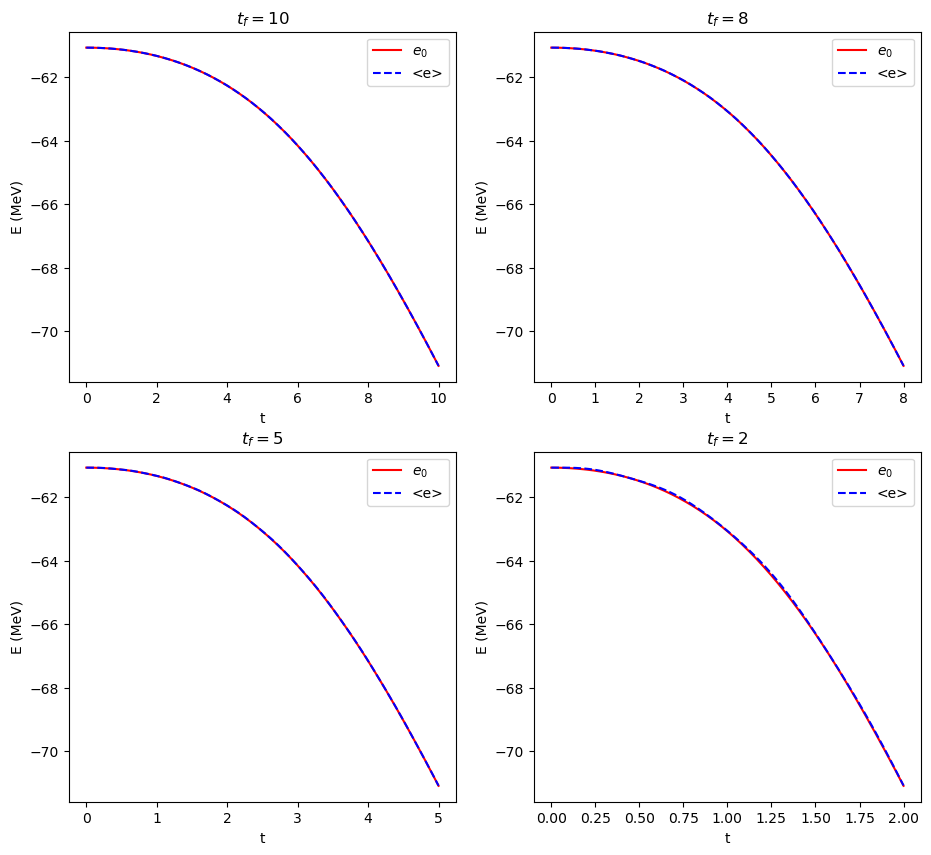

In [24]:
plt.figure(figsize=(11,10))
plt.subplot(221)
plt.title('$t_f = 10$')
plt.plot(time10, np.real(spectrum_arr_c10[:,0]), 'r-', label='$e_0$')
plt.plot(time10, np.real(energy_c10), 'b--', label='<e>')
plt.xlabel('t')
plt.ylabel('E (MeV)')
plt.legend()
plt.subplot(222)
plt.title('$t_f = 8$')
plt.plot(time8, np.real(spectrum_arr_c8[:,0]), 'r-', label='$e_0$')
plt.plot(time8, np.real(energy_c8), 'b--', label='<e>')
plt.xlabel('t')
plt.ylabel('E (MeV)')
plt.legend()
plt.subplot(223)
plt.title('$t_f = 5$')
plt.plot(time5, np.real(spectrum_arr_c5[:,0]), 'r-', label='$e_0$')
plt.plot(time5, np.real(energy_c5), 'b--', label='<e>')
plt.xlabel('t')
plt.ylabel('E (MeV)')
plt.legend()
plt.subplot(224)
plt.title('$t_f = 2$')
plt.plot(time2, np.real(spectrum_arr_c2[:,0]), 'r-', label='$e_0$')
plt.plot(time2, np.real(energy_c2), 'b--', label='<e>')
plt.xlabel('t')
plt.ylabel('E (MeV)')
plt.legend()

Fianlly, let's make a plot of the probabilities of population on time of the first 4 excited states for each time period

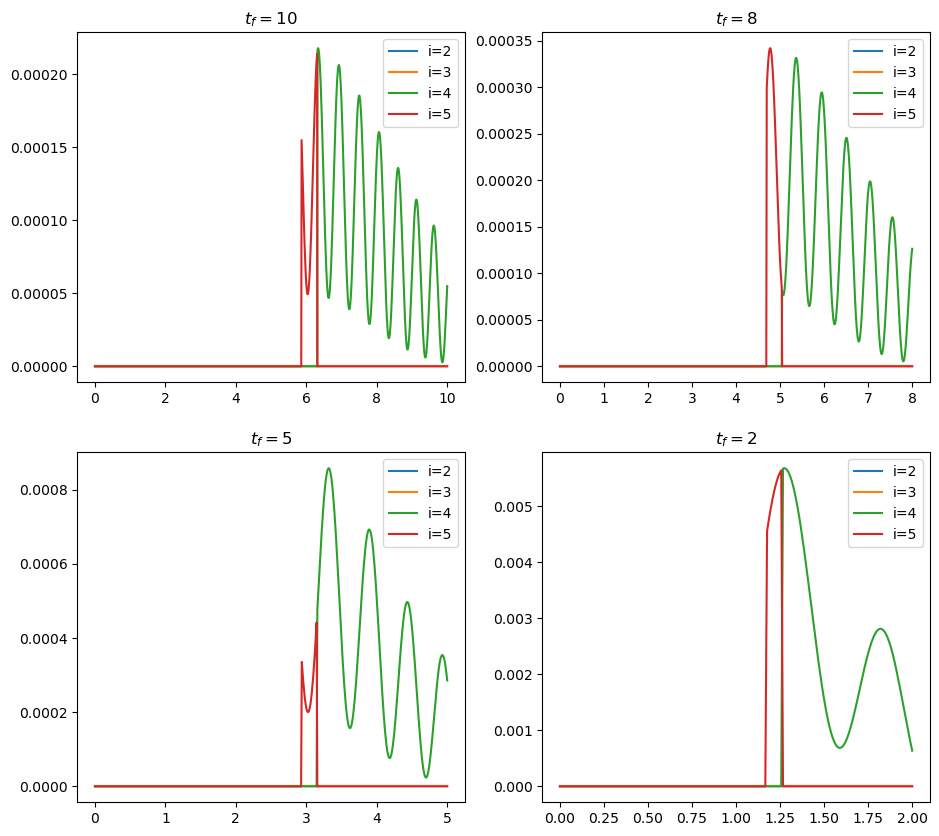

In [25]:
plt.figure(figsize=(11, 10))
plt.subplot(221)
plt.title('$t_f = 10$')
plt.plot(time10, prob_carr10[:,0], label='i=2')
plt.plot(time10, prob_carr10[:,1], label='i=3')
plt.plot(time10, prob_carr10[:,2], label='i=4')
plt.plot(time10, prob_carr10[:,3], label='i=5')
plt.legend()
plt.subplot(222)
plt.title('$t_f = 8$')
plt.plot(time8, prob_carr8[:,0], label='i=2')
plt.plot(time8, prob_carr8[:,1], label='i=3')
plt.plot(time8, prob_carr8[:,2], label='i=4')
plt.plot(time8, prob_carr8[:,3], label='i=5')
plt.legend()
plt.subplot(223)
plt.title('$t_f = 5$')
plt.plot(time5, prob_carr5[:,0], label='i=2')
plt.plot(time5, prob_carr5[:,1], label='i=3')
plt.plot(time5, prob_carr5[:,2], label='i=4')
plt.plot(time5, prob_carr5[:,3], label='i=5')
plt.legend()
plt.subplot(224)
plt.title('$t_f = 2$')
plt.plot(time2, prob_carr2[:,0], label='i=2')
plt.plot(time2, prob_carr2[:,1], label='i=3')
plt.plot(time2, prob_carr2[:,2], label='i=4')
plt.plot(time2, prob_carr2[:,3], label='i=5')
plt.legend()

# sd-shell
Having ended the study for the nuclei on the p-shell, let's continue with the sd-shell

In [26]:
# For the oxigen and neon isotopes, we'll use the following data set
sd_shell = 'data/usdb.nat'
SPS_sd = SingleParticleState(file_name = sd_shell)

# Let's print the single particle energies
print('single particle energies =', SPS_sd.energies)
print('mapping between nucleon modes a and quantum numbers:', SPS_sd.state_encoding)

nuc_modes_per_i_sd = SPS_sd.energies.shape[0] // 2   # counting per species!!

single particle energies = [-3.9257 -3.9257 -3.9257 -3.9257 -3.9257 -3.9257 -3.2079 -3.2079  2.1117
  2.1117  2.1117  2.1117 -3.9257 -3.9257 -3.9257 -3.9257 -3.9257 -3.9257
 -3.2079 -3.2079  2.1117  2.1117  2.1117  2.1117]
mapping between nucleon modes a and quantum numbers: [(0, 2, 2.5, -2.5, 0.5, 0.5), (0, 2, 2.5, -1.5, 0.5, 0.5), (0, 2, 2.5, -0.5, 0.5, 0.5), (0, 2, 2.5, 0.5, 0.5, 0.5), (0, 2, 2.5, 1.5, 0.5, 0.5), (0, 2, 2.5, 2.5, 0.5, 0.5), (1, 0, 0.5, -0.5, 0.5, 0.5), (1, 0, 0.5, 0.5, 0.5, 0.5), (0, 2, 1.5, -1.5, 0.5, 0.5), (0, 2, 1.5, -0.5, 0.5, 0.5), (0, 2, 1.5, 0.5, 0.5, 0.5), (0, 2, 1.5, 1.5, 0.5, 0.5), (0, 2, 2.5, -2.5, 0.5, -0.5), (0, 2, 2.5, -1.5, 0.5, -0.5), (0, 2, 2.5, -0.5, 0.5, -0.5), (0, 2, 2.5, 0.5, 0.5, -0.5), (0, 2, 2.5, 1.5, 0.5, -0.5), (0, 2, 2.5, 2.5, 0.5, -0.5), (1, 0, 0.5, -0.5, 0.5, -0.5), (1, 0, 0.5, 0.5, 0.5, -0.5), (0, 2, 1.5, -1.5, 0.5, -0.5), (0, 2, 1.5, -0.5, 0.5, -0.5), (0, 2, 1.5, 0.5, 0.5, -0.5), (0, 2, 1.5, 1.5, 0.5, -0.5)]


# $^{18}O$

In [27]:
# 18-O, 0 protons and 2 neutrons in the p-shell
po = 0
n18 = 2

NSM_H_18o = FermiHubbardHamiltonian(size_a=nuc_modes_per_i_sd, size_b=nuc_modes_per_i_sd, nparticles_a=n18, nparticles_b=po, 
                                symmetries=[SPS_sd.total_M_zero]) # we force M=0 so we don't get the full manybody basis

NSM_H_18o.get_external_potential(external_potential=SPS_sd.energies)
twobody_dict_18o, _ = get_twobody_nuclearshell_model(file_name=sd_shell)

NSM_H_18o.get_twobody_interaction(twobody_dict_18o)
NSM_H_18o.get_hamiltonian() # Now we have the Target Hamiltonian ready

egs_18o, psigs = NSM_H_18o.get_spectrum(n_states=1) # just the ground state (energy in MeV's)
print(f'GS energy = {egs_18o[0]:.5} MeV')
print(NSM_H_18o.hamiltonian.shape)

Computing the matrix, pls wait... (u_u) 



100%|██████████| 24/24 [00:53<00:00,  2.21s/it]
16496it [00:21, 754.68it/s]

GS energy = -11.932 MeV
(14, 14)


In [28]:
ini_base_el_18o = np.array([1.,0.,0.,0.,0.,1.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.,0.])
ini_idx = NSM_H_18o._get_index(ini_base_el_18o)
psi_ini_18o = np.zeros(NSM_H_18o.hamiltonian.shape[0])
psi_ini_18o[ini_idx] = 1
print(psi_ini_18o)
print(ini_base_el_18o)

# Get the external potential
ext_pot_18o = (NSM_H_18o.hamiltonian[ini_idx,ini_idx] / (po+ n18)) * ini_base_el_18o

# Now we get the Driver Hamiltonian
Driver_H_18o = FermiHubbardHamiltonian(size_a=nuc_modes_per_i_sd, size_b=nuc_modes_per_i_sd, nparticles_a=n18, nparticles_b=po, 
                                   symmetries=[SPS_sd.total_M_zero])
Driver_H_18o.get_external_potential(ext_pot_18o)
Driver_H_18o.get_hamiltonian()
print(Driver_H_18o.hamiltonian.shape)

[1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
[1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
(14, 14)


c:\Users\alber\anaconda3\Lib\site-packages\matplotlib\cbook\__init__.py:1340: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


FINAL ENERGIES (in MeV)
tf=10 -> -11.90696545579509
tf=8 -> -11.866888638745074
tf=5 -> -11.696695549481474
tf=2 -> -11.113445444788539
GS energy = -11.932 MeV


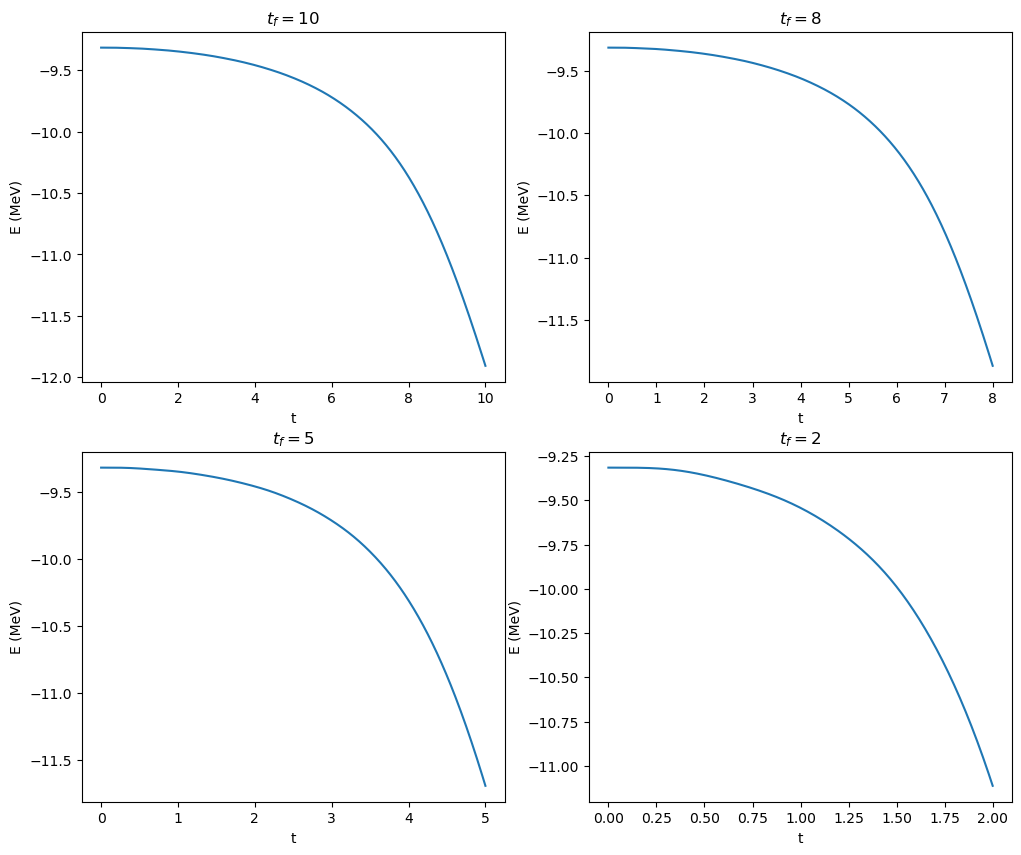

In [41]:
# dt=0.01 BECAUSE TOO MUCH DEVIATION
tf = 10
tsteps = 1000
dt = tf / tsteps
time10 = np.linspace(0, tf, tsteps)

psi_18o = psi_ini_18o.copy()
energy_18o10 = []
spectrum_t_18o = []
prob_18oarr = []

for i, t in enumerate(time10):
    prob_18o = []
    H_t_18o = (1 - t/tf) * Driver_H_18o.hamiltonian + (t/tf) * NSM_H_18o.hamiltonian
    energy_18o10.append(psi_18o.conjugate().transpose().dot(H_t_18o.dot(psi_18o))) # we append <psi|H(t)|psi>
    eigval_18o, eigvec_18o = eigsh(H_t_18o, k=5, which = 'SA') 
    spectrum_t_18o.append(eigval_18o)
    psi_18o = expm_multiply(-1j * dt * H_t_18o,psi_18o)
    for k in range(1,5):
        prob_18o.append(np.linalg.norm(psi_18o.conjugate().dot(eigvec_18o[:,k]))**2.0)
    prob_18oarr.append(prob_18o)
prob_18oarr10 = np.asarray(prob_18oarr)
spectrum_arr_18o10 = np.asarray(spectrum_t_18o)

# We plot the energy along time
plt.figure('18O', figsize=(12,10))
plt.subplot(221)
plt.title('$t_f = 10$')
plt.plot(time10, energy_18o10)
plt.xlabel('t')
plt.ylabel('E (MeV)')

# Let's study different final times, same dt=0.01
# FINAL TIME -> 8
tf8 = 8
tsteps8 = 800
dt = tf8 / tsteps8
time8 = np.linspace(0, tf8, tsteps8)

psi_18o = psi_ini_18o.copy()
energy_18o8 = []
spectrum_t_18o = []
prob_18oarr = []

for i, t in enumerate(time8):
    prob_18o = []
    H_t_18o = (1 - t/tf8) * Driver_H_18o.hamiltonian + (t/tf8) * NSM_H_18o.hamiltonian
    energy_18o8.append(psi_18o.conjugate().transpose().dot(H_t_18o.dot(psi_18o))) # we append <psi|H(t)|psi>
    eigval_18o, eigvec_18o = eigsh(H_t_18o, k=5, which = 'SA') 
    spectrum_t_18o.append(eigval_18o)
    psi_18o = expm_multiply(-1j * dt * H_t_18o,psi_18o)
    for k in range(1,5):
        prob_18o.append(np.linalg.norm(psi_18o.conjugate().dot(eigvec_18o[:,k]))**2.0)
    prob_18oarr.append(prob_18o)
prob_18oarr8 = np.asarray(prob_18oarr)
spectrum_arr_18o8 = np.asarray(spectrum_t_18o)

# We plot the energy along time
plt.subplot(222)
plt.title('$t_f = 8$')
plt.plot(time8, energy_18o8)
plt.xlabel('t')
plt.ylabel('E (MeV)')

# FINAL TIME -> 5
tf5 = 5
tsteps5 = 500
dt = tf5 / tsteps5
time5 = np.linspace(0, tf5, tsteps5)

psi_18o = psi_ini_18o.copy()
energy_18o5 = []
spectrum_t_18o = []
prob_18oarr = []

for i, t in enumerate(time5):
    prob_18o = []
    H_t_18o = (1 - t/tf5) * Driver_H_18o.hamiltonian + (t/tf5) * NSM_H_18o.hamiltonian
    energy_18o5.append(psi_18o.conjugate().transpose().dot(H_t_18o.dot(psi_18o))) # we append <psi|H(t)|psi>
    eigval_18o, eigvec_18o = eigsh(H_t_18o, k=5, which = 'SA') 
    spectrum_t_18o.append(eigval_18o)
    psi_18o = expm_multiply(-1j * dt * H_t_18o,psi_18o)
    for k in range(1,5):
        prob_18o.append(np.linalg.norm(psi_18o.conjugate().dot(eigvec_18o[:,k]))**2.0)
    prob_18oarr.append(prob_18o)
prob_18oarr5 = np.asarray(prob_18oarr)
spectrum_arr_18o5 = np.asarray(spectrum_t_18o)

# We plot the energy along time
plt.subplot(223)
plt.title('$t_f = 5$')
plt.plot(time5, energy_18o5)
plt.xlabel('t')
plt.ylabel('E (MeV)')

# FINAL TIME -> 2
tf2 = 2
tsteps2 = 200
dt = tf2 / tsteps2
time2 = np.linspace(0, tf2, tsteps2)

psi_18o = psi_ini_18o.copy()
energy_18o2 = []
spectrum_t_18o = []
prob_18oarr = []

for i, t in enumerate(time2):
    prob_18o = []
    H_t_18o = (1 - t/tf2) * Driver_H_18o.hamiltonian + (t/tf2) * NSM_H_18o.hamiltonian
    energy_18o2.append(psi_18o.conjugate().transpose().dot(H_t_18o.dot(psi_18o))) # we append <psi|H(t)|psi>
    eigval_18o, eigvec_18o = eigsh(H_t_18o, k=5, which = 'SA') 
    spectrum_t_18o.append(eigval_18o)
    psi_18o = expm_multiply(-1j * dt * H_t_18o,psi_18o)
    for k in range(1,5):
        prob_18o.append(np.linalg.norm(psi_18o.conjugate().dot(eigvec_18o[:,k]))**2.0)
    prob_18oarr.append(prob_18o)
prob_18oarr2 = np.asarray(prob_18oarr)
spectrum_arr_18o2 = np.asarray(spectrum_t_18o)

# We plot the energy along time
plt.subplot(224)
plt.title('$t_f = 2$')
plt.plot(time2, energy_18o2)
plt.xlabel('t')
plt.ylabel('E (MeV)')

# Let's print the final energies compared to the GS
print('FINAL ENERGIES (in MeV)')
print('tf=10 ->', np.real(energy_18o10[tsteps-1]))
print('tf=8 ->', np.real(energy_18o8[tsteps8-1]))
print('tf=5 ->', np.real(energy_18o5[tsteps5-1]))
print('tf=2 ->', np.real(energy_18o2[tsteps2-1]))
print(f'GS energy = {egs_18o[0]:.5} MeV')

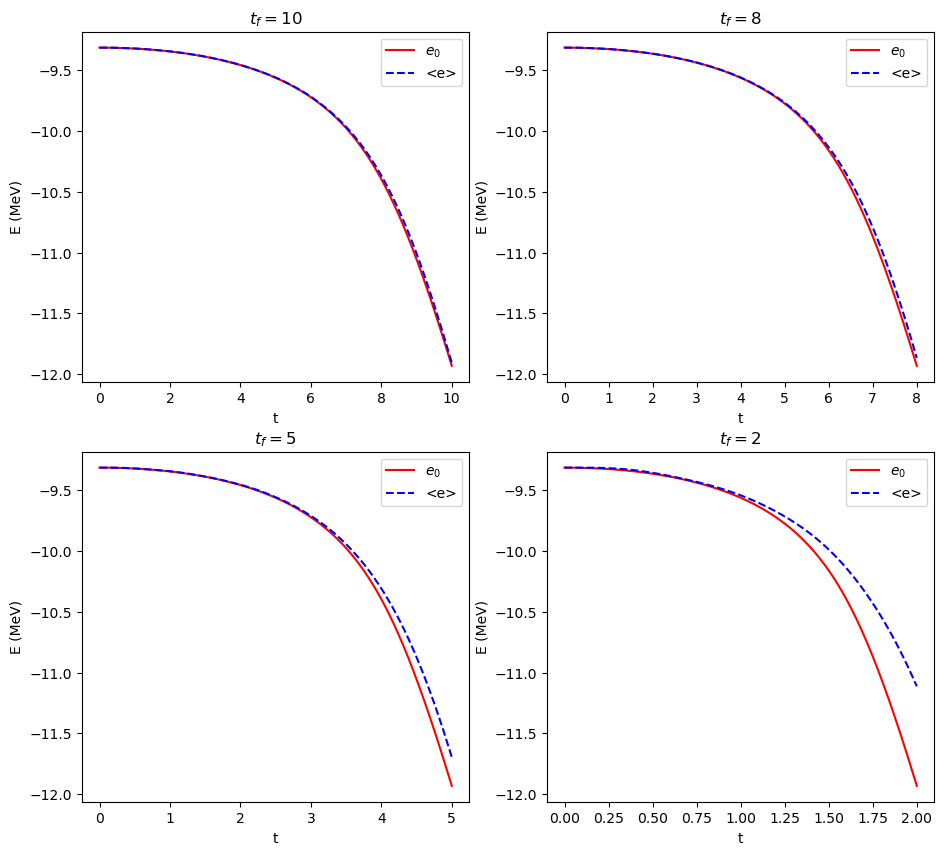

In [42]:
plt.figure(figsize=(11,10))
plt.subplot(221)
plt.title('$t_f = 10$')
plt.plot(time10, np.real(spectrum_arr_18o10[:,0]), 'r-', label='$e_0$')
plt.plot(time10, np.real(energy_18o10), 'b--', label='<e>')
plt.xlabel('t')
plt.ylabel('E (MeV)')
plt.legend()
plt.subplot(222)
plt.title('$t_f = 8$')
plt.plot(time8, np.real(spectrum_arr_18o8[:,0]), 'r-', label='$e_0$')
plt.plot(time8, np.real(energy_18o8), 'b--', label='<e>')
plt.xlabel('t')
plt.ylabel('E (MeV)')
plt.legend()
plt.subplot(223)
plt.title('$t_f = 5$')
plt.plot(time5, np.real(spectrum_arr_18o5[:,0]), 'r-', label='$e_0$')
plt.plot(time5, np.real(energy_18o5), 'b--', label='<e>')
plt.xlabel('t')
plt.ylabel('E (MeV)')
plt.legend()
plt.subplot(224)
plt.title('$t_f = 2$')
plt.plot(time2, np.real(spectrum_arr_18o2[:,0]), 'r-', label='$e_0$')
plt.plot(time2, np.real(energy_18o2), 'b--', label='<e>')
plt.xlabel('t')
plt.ylabel('E (MeV)')
plt.legend()

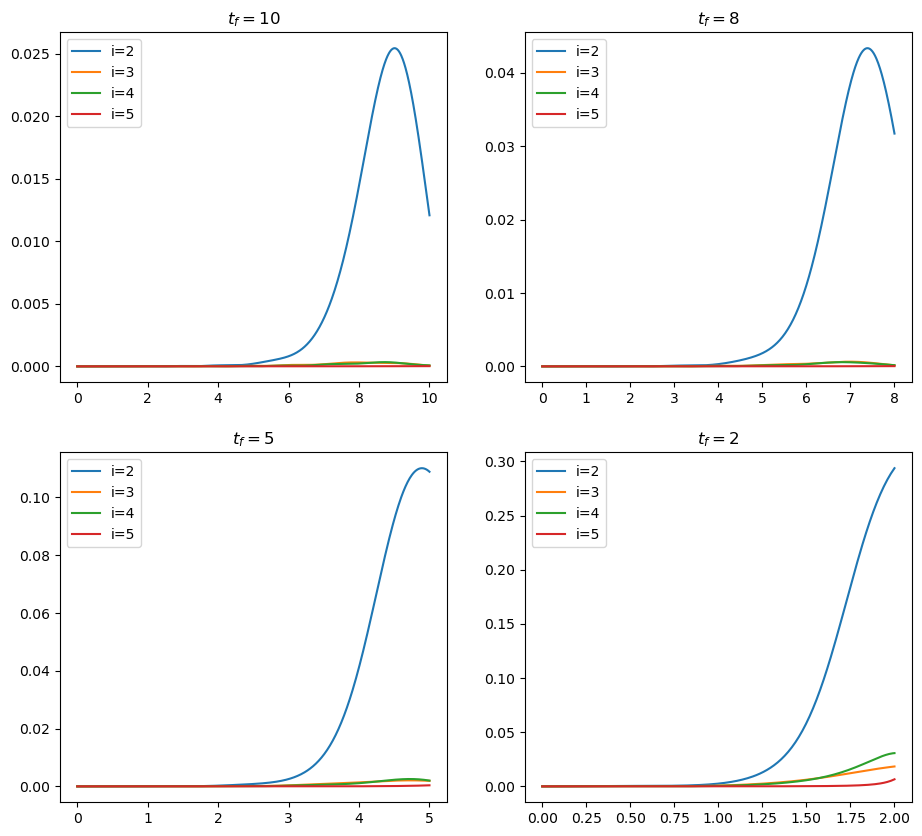

In [47]:
plt.figure(figsize=(11, 10))
plt.subplot(221)
plt.title('$t_f = 10$')
plt.plot(time10, prob_18oarr10[:,0], label='i=2')
plt.plot(time10, prob_18oarr10[:,1], label='i=3')
plt.plot(time10, prob_18oarr10[:,2], label='i=4')
plt.plot(time10, prob_18oarr10[:,3], label='i=5')
plt.legend()
plt.subplot(222)
plt.title('$t_f = 8$')
plt.plot(time8, prob_18oarr8[:,0], label='i=2')
plt.plot(time8, prob_18oarr8[:,1], label='i=3')
plt.plot(time8, prob_18oarr8[:,2], label='i=4')
plt.plot(time8, prob_18oarr8[:,3], label='i=5')
plt.legend()
plt.subplot(223)
plt.title('$t_f = 5$')
plt.plot(time5, prob_18oarr5[:,0], label='i=2')
plt.plot(time5, prob_18oarr5[:,1], label='i=3')
plt.plot(time5, prob_18oarr5[:,2], label='i=4')
plt.plot(time5, prob_18oarr5[:,3], label='i=5')
plt.legend()
plt.subplot(224)
plt.title('$t_f = 2$')
plt.plot(time2, prob_18oarr2[:,0], label='i=2')
plt.plot(time2, prob_18oarr2[:,1], label='i=3')
plt.plot(time2, prob_18oarr2[:,2], label='i=4')
plt.plot(time2, prob_18oarr2[:,3], label='i=5')
plt.legend()